# Tire Degradation Prediction Model - Week 5

## Overview
This notebook implements advanced models to predict tire degradation in Formula 1 races. Since tire degradation is not strictly linear and depends on multiple factors (compound type, track temperature, driving style, etc.), we'll use sequence models like LSTM to capture these complex patterns.

## Approach
1. **Data Exploration**
   - Analyze the relationship between lap times and tire age
   - Visualize performance degradation patterns by compound
   - Determine how to quantify "degradation" (lap time delta or derived metric)

2. **Feature Engineering**
   - Create a derived tire degradation metric
   - Organize data into sequential format for LSTM
   - Normalize features appropriately
   - Create sliding windows of previous laps to predict future performance

3. **Model Development**
   - **Primary Model**: LSTM network to predict degradation trajectory
   - **Alternative Model**: XGBoost with quantile regression for uncertainty estimation

4. **Evaluation & Visualization**
   - Compare predicted vs. actual degradation curves
   - Analyze performance across different compounds and race conditions
   - Create interactive Plotly visualizations of degradation patterns

5. **Implementation Details**
   - Sequence length: 5 laps (input) → predict next 3-5 laps
   - Features: Tire age, compound, lap time trends, fuel load
   - Target: Derived degradation metric or direct lap time prediction

## Expected Outcomes
- Trained model to predict tire performance over extended stints
- Uncertainty bounds for degradation predictions (10th, 50th, 90th percentiles)
- Interactive visualization of degradation curves by compound

---

## 1. Importing Necessary Libraries and Creatind New Directories

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [4]:
# Import utility functions from our module
from ML_utils.lap_prediction import compound_colors, compound_names

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create output directories if they don't exist
os.makedirs('../../outputs/week5/models', exist_ok=True)


Model loaded succesfully
Model waits for 13 features
['Stint' 'SpeedI1' 'SpeedI2' 'SpeedFL' 'SpeedST' 'Position'
 'LapsSincePitStop' 'DRSUsed' 'TeamID' 'CompoundID' 'TyreAge' 'FuelLoad'
 'DriverNumber']


---

## 2. Loading Dataframes

In [5]:
data = pd.read_csv("../../outputs/week3/lap_prediction_data.csv")
print("\nRegular data sample:")
display(data.head())


Regular data sample:


,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber
0,0,83.935,1.0,256.0,261.0,276.0,275.0,1.0,1.0,0,9,2,1.0,0.9848,1
1,1,80.402,1.0,252.0,257.0,276.0,295.0,1.0,2.0,0,9,2,2.0,0.9697,1
2,2,80.499,1.0,249.0,256.0,276.0,297.0,1.0,3.0,0,9,2,3.0,0.9545,1
3,3,80.346,1.0,255.0,256.0,276.0,300.0,1.0,4.0,0,9,2,4.0,0.9394,1
4,4,80.283,1.0,254.0,256.0,277.0,301.0,1.0,5.0,0,9,2,5.0,0.9242,1


In [6]:
seq_data = pd.read_csv("../../outputs/week3/sequential_lap_prediction_data.csv")
print("\nSequential data sample:")
display(seq_data.head())


Sequential data sample:


,Unnamed: 0.1,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,...,Prev_SpeedI2,Prev_SpeedFL,Prev_SpeedST,Prev_TyreAge,LapTime_Delta,SpeedI1_Delta,SpeedI2_Delta,SpeedFL_Delta,SpeedST_Delta,LapTime_Trend
0,1,1.0,80.402,1.0,252.0,257.0,276.0,295.00,1.0,2.0,...,261.0,276.0,275.0,1.0,-3.533,-4.0,-4.0,0.0,20.00,0.000
1,2,2.0,80.499,1.0,249.0,256.0,276.0,297.00,1.0,3.0,...,257.0,276.0,295.0,2.0,0.097,-3.0,-1.0,0.0,2.00,3.630
2,3,3.0,80.346,1.0,255.0,256.0,276.0,300.00,1.0,4.0,...,256.0,276.0,297.0,3.0,-0.153,6.0,0.0,0.0,3.00,-0.250
3,4,4.0,80.283,1.0,254.0,256.0,277.0,301.00,1.0,5.0,...,256.0,276.0,300.0,4.0,-0.063,-1.0,0.0,1.0,1.00,0.090
4,5,5.0,80.402,1.0,255.0,253.0,276.0,309.85,1.0,6.0,...,256.0,277.0,301.0,5.0,0.119,1.0,-3.0,-1.0,8.85,0.182


In [7]:
# Display basic information
print("Basic dataset information:")
print(f"Regular data shape: {data.shape}")
print(f"Sequential data shape: {seq_data.shape}")

Basic dataset information:
Regular data shape: (1180, 15)
Sequential data shape: (1118, 28)


---

## 3. Locating Tire Related Columns


In [8]:
# Check for tire-related columns
tire_columns = ['CompoundID', 'TyreAge']
print(f"\nTire-related columns: {tire_columns}")


Tire-related columns: ['CompoundID', 'TyreAge']


In [9]:
# Summary statistics for tire-related columns
print("\nTire-related statistics:")
display(data[tire_columns].describe())


Tire-related statistics:


,CompoundID,TyreAge
count,1180.000000,1180.000000
mean,2.188136,13.760169
std,0.800887,8.002074
min,1.000000,1.000000
25%,2.000000,7.000000
50%,2.000000,13.000000
75%,3.000000,19.000000
max,3.000000,50.000000


---

## 4. Compound Mappings

In [10]:
# Print compound mappings for reference
print("\nCompound mappings:")
print(f"Compound names: {compound_names}")
print(f"Compound colors: {compound_colors}")


Compound mappings:
Compound names: {1: 'SOFT', 2: 'MEDIUM', 3: 'HARD', 4: 'INTERMEDIATE', 5: 'WET'}
Compound colors: {1: 'red', 2: 'yellow', 3: 'gray', 4: 'green', 5: 'blue'}


---

## 5. Analyzing Relationship between Tire Age and Lap Time by compound

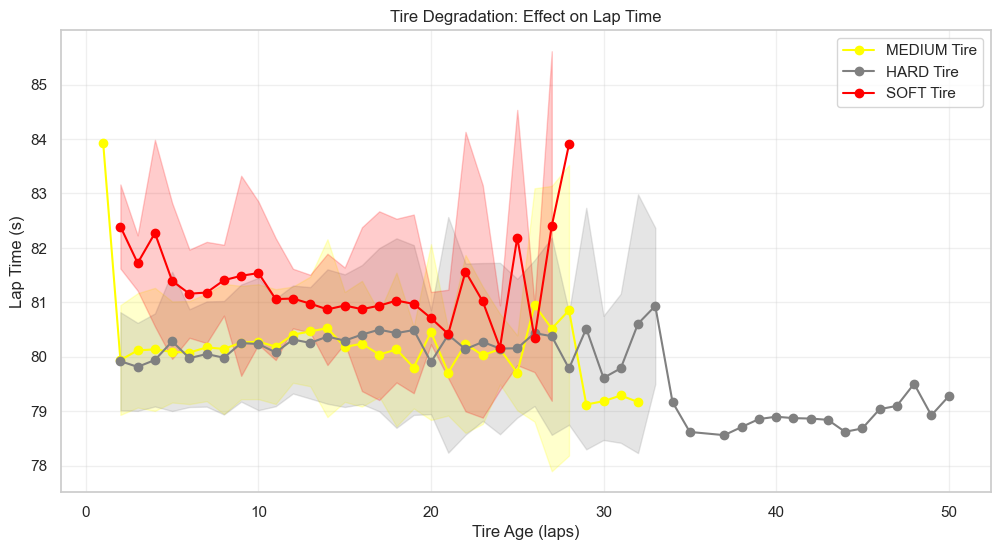

In [11]:
# Visualize the relationship between tire age and lap time by compound
plt.figure(figsize=(12, 6))

# Group by compound and tire age
for compound_id in data['CompoundID'].unique():
    subset = data[data['CompoundID'] == compound_id]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')['LapTime'].agg(['mean', 'std', 'count']).reset_index()
    
    # Only plot if we have enough data points
    if len(agg_data) > 1:
        color = compound_colors.get(compound_id, 'black')
        compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
        
        plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
                 color=color, label=f'{compound_name} Tire')
        
        # Add error bands (standard deviation)
        if 'std' in agg_data.columns:
            plt.fill_between(agg_data['TyreAge'], 
                            agg_data['mean'] - agg_data['std'], 
                            agg_data['mean'] + agg_data['std'],
                            color=color, alpha=0.2)

plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tire Degradation: Effect on Lap Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_curve.png')
plt.show()

---

## 6. Exploring Lap Times Deltas and Tire Ages

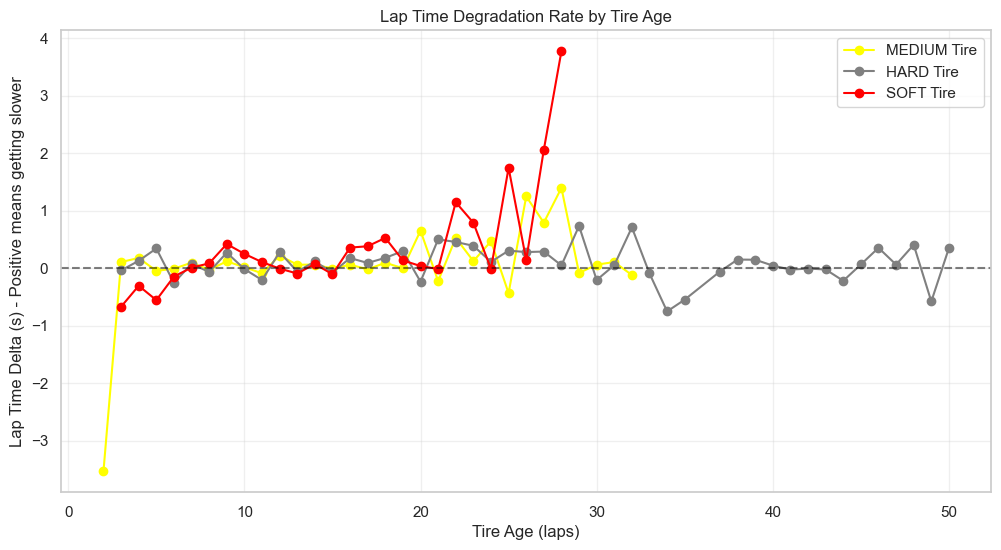

In [12]:
# Explore lap time deltas as tire ages
if 'LapTime_Delta' in seq_data.columns:
    plt.figure(figsize=(12, 6))
    
    for compound_id in seq_data['CompoundID'].unique():
        subset = seq_data[seq_data['CompoundID'] == compound_id]
        
        # Aggregate by tire age
        agg_data = subset.groupby('TyreAge')['LapTime_Delta'].mean().reset_index()
        
        # Only plot if we have enough data points
        if len(agg_data) > 1:
            color = compound_colors.get(compound_id, 'black')
            compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
            
            plt.plot(agg_data['TyreAge'], agg_data['LapTime_Delta'], 'o-', 
                     color=color, label=f'{compound_name} Tire')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Lap Time Delta (s) - Positive means getting slower')
    plt.title('Lap Time Degradation Rate by Tire Age')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../../outputs/week5/tire_deg_rate.png')
    plt.show()

---

## 7. Exploring if Tire Age affects Speed in different Sectors

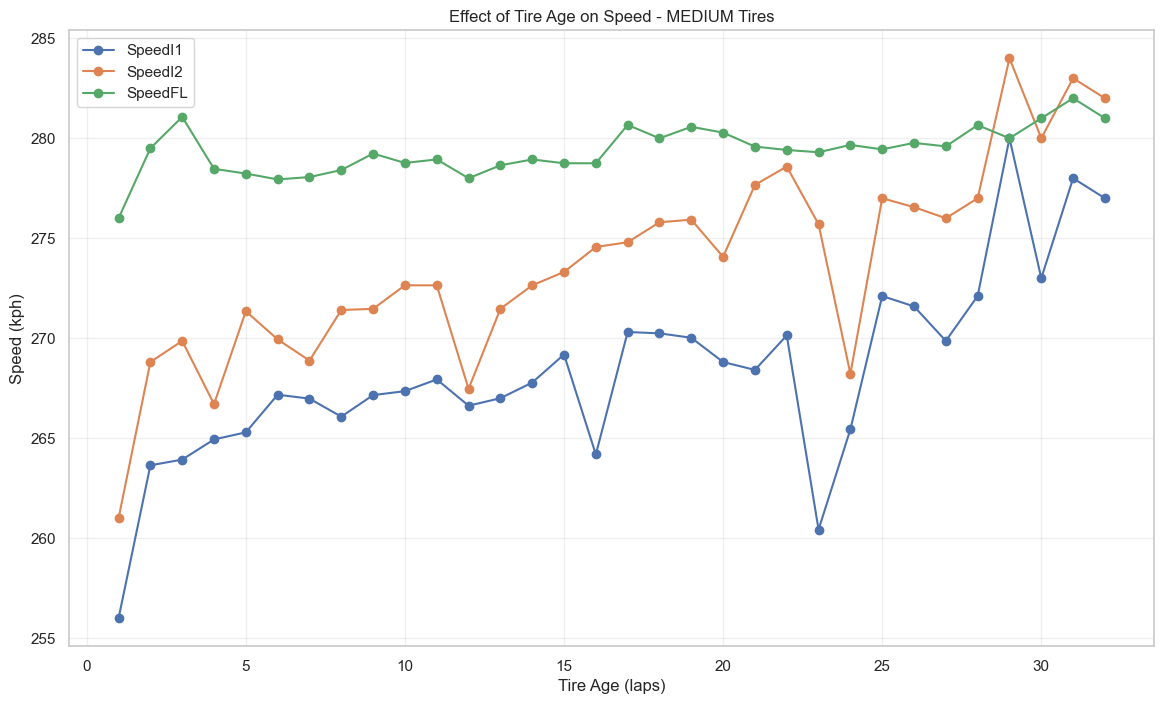

In [13]:
# Look at how tire age affects speed in different sectors
speed_columns = ['SpeedI1', 'SpeedI2', 'SpeedFL']

plt.figure(figsize=(14, 8))
for speed_col in speed_columns:
    # Focus on compound ID 2 (Medium) since that's what we have in the data
    subset = data[data['CompoundID'] == 2]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')[speed_col].mean().reset_index()
    
    if len(agg_data) > 1:
        plt.plot(agg_data['TyreAge'], agg_data[speed_col], 'o-', 
                 label=f'{speed_col}')

plt.xlabel('Tire Age (laps)')
plt.ylabel('Speed (kph)')
plt.title(f'Effect of Tire Age on Speed - {compound_names.get(2)} Tires')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_age_speed_effect.png')
plt.show()

---

## 8. Creating Tire Degradation Metrics

For being able to predict tyre degradation more effectively, a good option can be generate more variables with the current data that we have. Therefore, I´ll add this new variables:

## Disclaimer: importance of fuel load.

After making the cells and looking at the data, some tires shows positive degradation. That means that lap times are descending instead of going up. This is caused due to the less amount of fuel during the race. Therefore, I need to **create an adjusted lap time** that takes into account this fuel factor before creating our prediction models. 

Then, I will create this variable and then adjust the plots and variable calculation for fitting this feature.

*NOTE*: fuel burn calculation and impact will be calculated according to this articles: 

- [BBC Sport Weight Reduction](https://www.bbc.com/sport/articles/cv2g715dkk1o#:~:text=A%201.5kg%20reduction%20in,so%20over%20a%20race%20distance.)

- [Fuel Correction Analysis, Medium](https://medium.com/@umakschually/fuel-correction-29ccd98ae62b#:~:text=Rule%20of%20thumb%20is%20that,tyre%20age%20or%20anything%20else.)

#### 1. Absolute Tire Degradation (TireDegAbsolute)

Its objective is to **measure how much seconds is the actual lap time slower, compared with the baseline** (new tires or with the less degradation possible, for instance, only 2 laps).

**Positive values** implie degradation (car is getting slower). As I said, it would be measured in **seconds**.

- *Utility*:
    - Allows knowing the direct impact on lap time.
    - Helps to determine the *cross point* when a pit stop becomes an advantage.
    - Fundamental for strategic calculus, as teams work with absolute times.
    - Helps us answering the following: **How many seconds are we losing per lap with degradation?**

#### 2. Tire Degradation Percentage 

It expresses degradation as an **augmenting percentage** to base time. For instance, 2% means the car is 2% slower than with new tires.

- *Utility*:
    - Allows more intuitive comparisons between different conditions.
    - Normalizes the data for more clear comparisons between tires.
    - Helps us aswering the following:**Which compound maintains better its relative performance?**

#### 3. Degradation Rate

Means how much time increases per lap with each aditional lap. Represents the first derivative of degradation curve. 

- *Utility:*
    - Allows knowing if degradation is lineal, progressive or if it stabilizes.
    - Crucial for estimating optimum pit stop window during races.
    - Allows anticipating future compound´s behaviour.
    - Helps us answering the following: **Degradation is getting worse or it is stabilizing?**.



---

### Calculating Lap Time Improvement Per Lap

In [14]:
# Crear métricas de degradación ajustadas usando directamente la mejora de tiempo por vuelta
# Tiempo que mejora cada vuelta debido a la reducción de combustible
LAP_TIME_IMPROVEMENT_PER_LAP = 0.055  # segundos por vuelta (punto medio de 0.05-0.06s)

# Create a DataFrame to store all results with fuel adjustment
tire_deg_data = pd.DataFrame()

# Process each compound separately
for compound_id in data['CompoundID'].unique():
    compound_name = compound_names.get(compound_id, f"Unknown ({compound_id})")
    print(f"Processing {compound_name} tires (ID: {compound_id})...")
    
    # Filter for this compound
    compound_data = data[data['CompoundID'] == compound_id].copy()
    
    # Sort by TyreAge to see the degradation trend
    compound_data = compound_data.sort_values('TyreAge')
    
    # Check if we have enough data
    if len(compound_data) < 5:
        print(f"  Not enough data for {compound_name} tires, skipping")
        continue
    
    # Find baseline information
    if 1 in compound_data['TyreAge'].values:
        # Get baseline data (TyreAge=1)
        baseline_data = compound_data[compound_data['TyreAge'] == 1]
        baseline_lap_time = baseline_data['LapTime'].mean()
        baseline_tire_age = 1
    else:
        # If no 'new tire' laps, use the minimum TyreAge available
        min_age = compound_data['TyreAge'].min()
        baseline_data = compound_data[compound_data['TyreAge'] == min_age]
        baseline_lap_time = baseline_data['LapTime'].mean()
        baseline_tire_age = min_age
        print(f"  No laps with new tires for {compound_name}, using TyreAge={min_age} as baseline")
    
    # Calculate fuel adjustment directly based on laps from baseline
    compound_data['LapsFromBaseline'] = compound_data['TyreAge'] - baseline_tire_age
    compound_data['FuelEffect'] = compound_data['LapsFromBaseline'] * LAP_TIME_IMPROVEMENT_PER_LAP
    
    # Calculate fuel-adjusted lap time
    compound_data['FuelAdjustedLapTime'] = compound_data['LapTime'] + compound_data['FuelEffect']
    
    # Calculate traditional degradation metrics
    compound_data['TireDegAbsolute'] = compound_data['LapTime'] - baseline_lap_time
    compound_data['TireDegPercent'] = (compound_data['LapTime'] / baseline_lap_time - 1) * 100
    
    # Calculate fuel-adjusted degradation metrics
    baseline_adjusted_lap_time = baseline_lap_time  # For new tires, no adjustment needed
    compound_data['FuelAdjustedDegAbsolute'] = compound_data['FuelAdjustedLapTime'] - baseline_adjusted_lap_time
    compound_data['FuelAdjustedDegPercent'] = (compound_data['FuelAdjustedLapTime'] / baseline_adjusted_lap_time - 1) * 100
    
    # Add compound info for later aggregation
    compound_data['CompoundName'] = compound_name
    
    # Add to the combined DataFrame
    tire_deg_data = pd.concat([tire_deg_data, compound_data])
    
    # Calculate maximum laps and total fuel effect
    max_laps = compound_data['TyreAge'].max() - baseline_tire_age
    total_fuel_effect = max_laps * LAP_TIME_IMPROVEMENT_PER_LAP
    
    print(f"  Baseline lap time for {compound_name}: {baseline_lap_time:.3f}s")
    print(f"  Maximum laps from baseline: {max_laps:.0f}")
    print(f"  Estimated total fuel benefit: ~{total_fuel_effect:.2f}s")
    print(f"  Processed {len(compound_data)} laps with {compound_name} tires")

# Display comparison between regular and fuel-adjusted metrics
print("\nComparison of regular vs. fuel-adjusted metrics (sample):")
sample_comparison = tire_deg_data.groupby(['CompoundName', 'TyreAge'])[
    ['TireDegAbsolute', 'FuelAdjustedDegAbsolute', 'FuelEffect']
].mean().reset_index()
display(sample_comparison.head(10))


Processing MEDIUM tires (ID: 2)...
  Baseline lap time for MEDIUM: 83.935s
  Maximum laps from baseline: 31
  Estimated total fuel benefit: ~1.71s
  Processed 382 laps with MEDIUM tires
Processing HARD tires (ID: 3)...
  No laps with new tires for HARD, using TyreAge=2.0 as baseline
  Baseline lap time for HARD: 79.917s
  Maximum laps from baseline: 48
  Estimated total fuel benefit: ~2.64s
  Processed 510 laps with HARD tires
Processing SOFT tires (ID: 1)...
  No laps with new tires for SOFT, using TyreAge=2.0 as baseline
  Baseline lap time for SOFT: 82.392s
  Maximum laps from baseline: 26
  Estimated total fuel benefit: ~1.43s
  Processed 288 laps with SOFT tires

Comparison of regular vs. fuel-adjusted metrics (sample):


,CompoundName,TyreAge,TireDegAbsolute,FuelAdjustedDegAbsolute,FuelEffect
0,HARD,2.0,2.243819e-15,2.243819e-15,0.000
1,HARD,3.0,-1.049184e-01,-4.991842e-02,0.055
2,HARD,4.0,2.213158e-02,1.321316e-01,0.110
3,HARD,5.0,3.637316e-01,5.287316e-01,0.165
4,HARD,6.0,5.582206e-02,2.758221e-01,0.220
5,HARD,7.0,1.311554e-01,4.061554e-01,0.275
6,HARD,8.0,6.310777e-02,3.931078e-01,0.330
7,HARD,9.0,3.324887e-01,7.174887e-01,0.385
8,HARD,10.0,3.162982e-01,7.562982e-01,0.440
9,HARD,11.0,1.606816e-01,6.556816e-01,0.495


---

### Plotting the Diferrence between regular and Fuel Adjusted Degradation

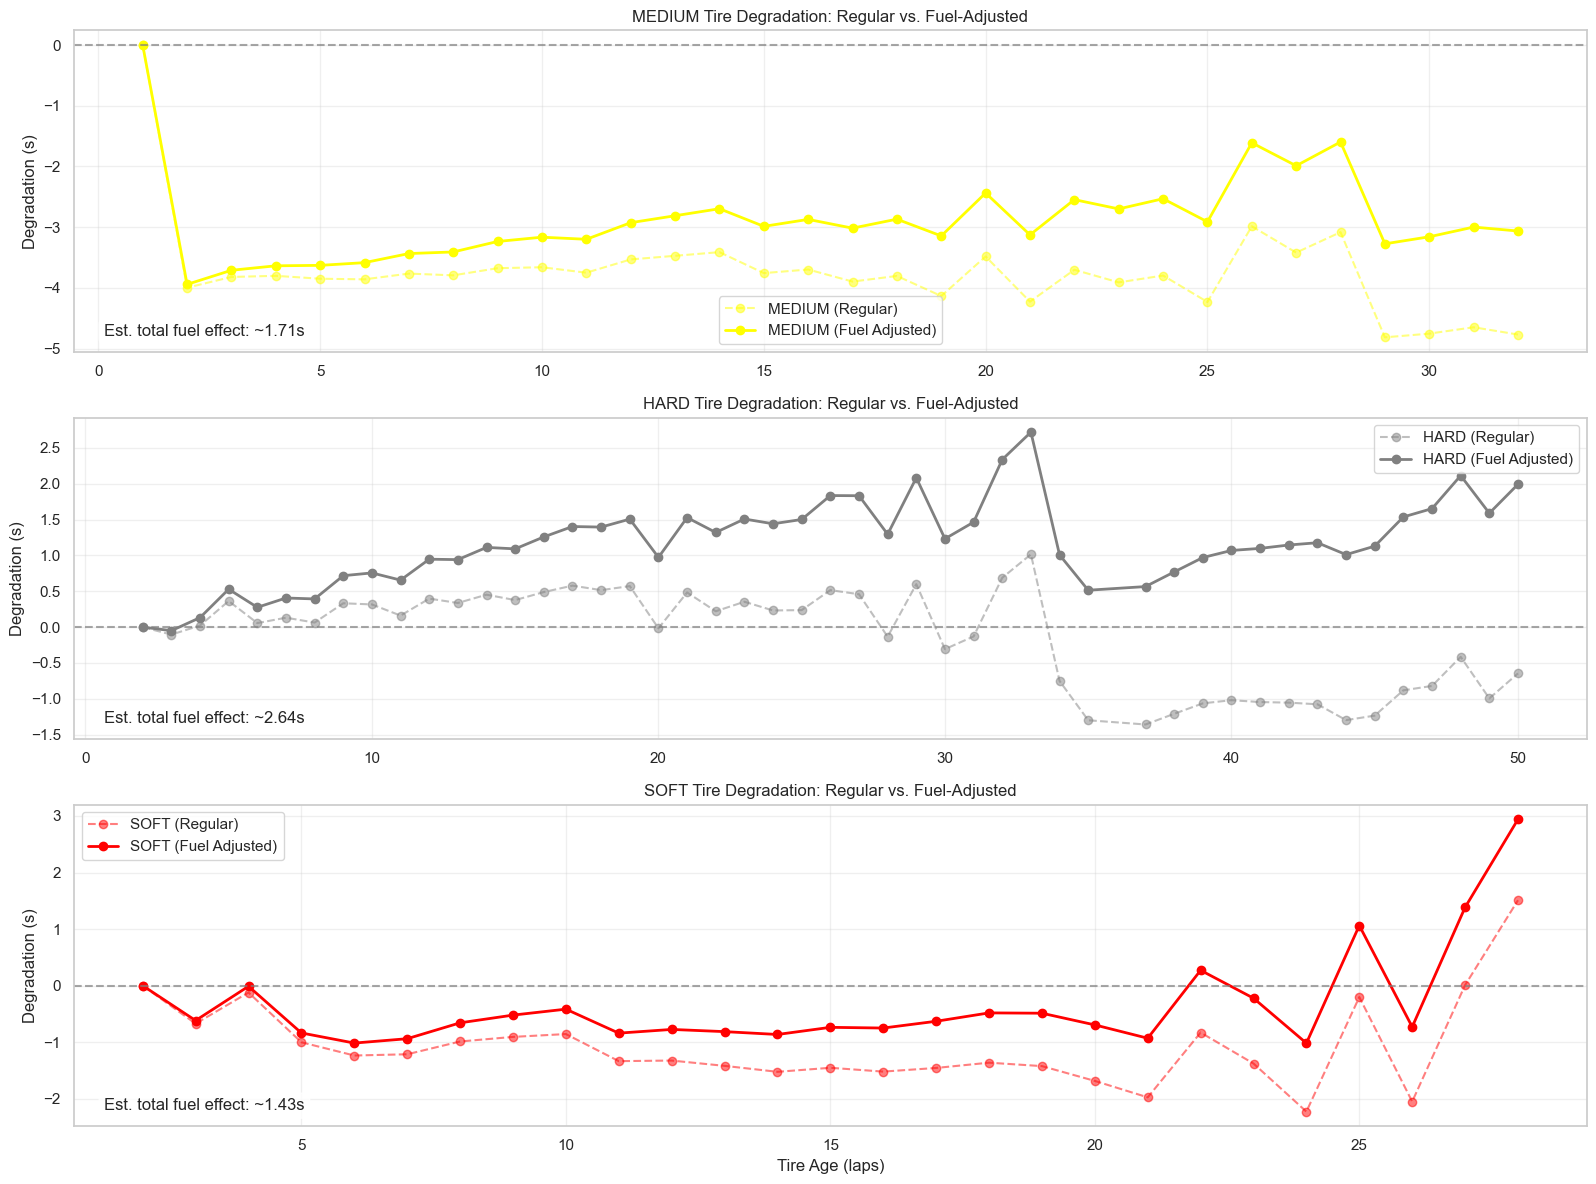

In [15]:
# Create a comparison of regular vs fuel-adjusted degradation
plt.figure(figsize=(16, 12))
compound_ids = tire_deg_data['CompoundID'].unique()
# Loop through the compounds to create comparison plots
for i, compound_id in enumerate(compound_ids):
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Calculate means for regular and adjusted degradation
    reg_agg = compound_subset.groupby('TyreAge')['TireDegAbsolute'].mean()
    adj_agg = compound_subset.groupby('TyreAge')['FuelAdjustedDegAbsolute'].mean()
    
    # Create subplot
    plt.subplot(len(compound_ids), 1, i+1)
    
    # Plot regular degradation
    plt.plot(reg_agg.index, reg_agg.values, 'o--', 
             color=color, alpha=0.5, label=f'{compound_name} (Regular)')
    
    # Plot fuel-adjusted degradation
    plt.plot(adj_agg.index, adj_agg.values, 'o-', 
             color=color, linewidth=2, label=f'{compound_name} (Fuel Adjusted)')
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    plt.ylabel('Degradation (s)')
    plt.title(f'{compound_name} Tire Degradation: Regular vs. Fuel-Adjusted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Anotar la diferencia total estimada del efecto combustible
    min_lap = reg_agg.index.min()
    max_lap = reg_agg.index.max()
    total_laps = max_lap - min_lap
    total_fuel_effect = total_laps * LAP_TIME_IMPROVEMENT_PER_LAP
    plt.annotate(f"Est. total fuel effect: ~{total_fuel_effect:.2f}s", 
                 xy=(0.02, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    if i == len(compound_ids)-1:  # Solo añadir etiqueta x para el subgráfico inferior
        plt.xlabel('Tire Age (laps)')

plt.tight_layout()
plt.savefig('../../outputs/week5/regular_vs_adjusted_comparison.png')
plt.show()


---

### 8.1 Absolute Tire Degradation

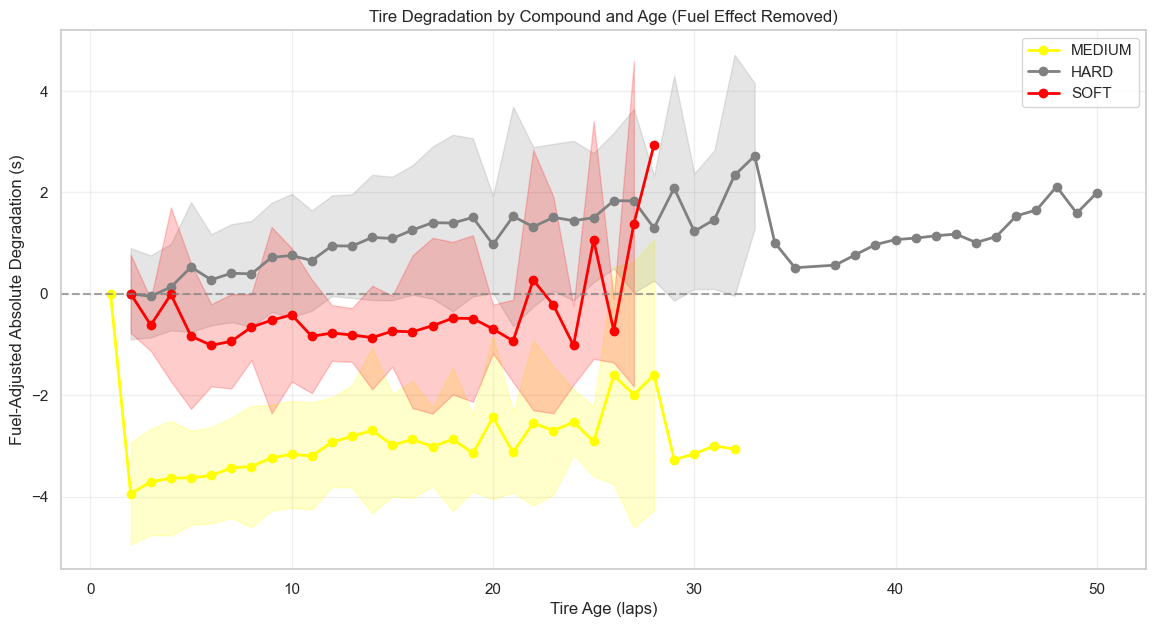

In [16]:
# Visualize the fuel-adjusted absolute degradation
plt.figure(figsize=(14, 7))
compound_ids = tire_deg_data['CompoundID'].unique()

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Aggregate data for line plot
    agg_data = compound_subset.groupby('TyreAge')['FuelAdjustedDegAbsolute'].agg(['mean', 'std']).reset_index()
    
    # Plot mean line
    plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')
    
    # Add error bands if we have standard deviation
    if 'std' in agg_data.columns and not agg_data['std'].isnull().all():
        plt.fill_between(agg_data['TyreAge'], 
                        agg_data['mean'] - agg_data['std'], 
                        agg_data['mean'] + agg_data['std'],
                        color=color, alpha=0.2)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Fuel-Adjusted Absolute Degradation (s)')
plt.title('Tire Degradation by Compound and Age (Fuel Effect Removed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/fuel_adjusted_deg_by_compound.png')
plt.show()

---

### 8.2 Tire Degradation Percentage

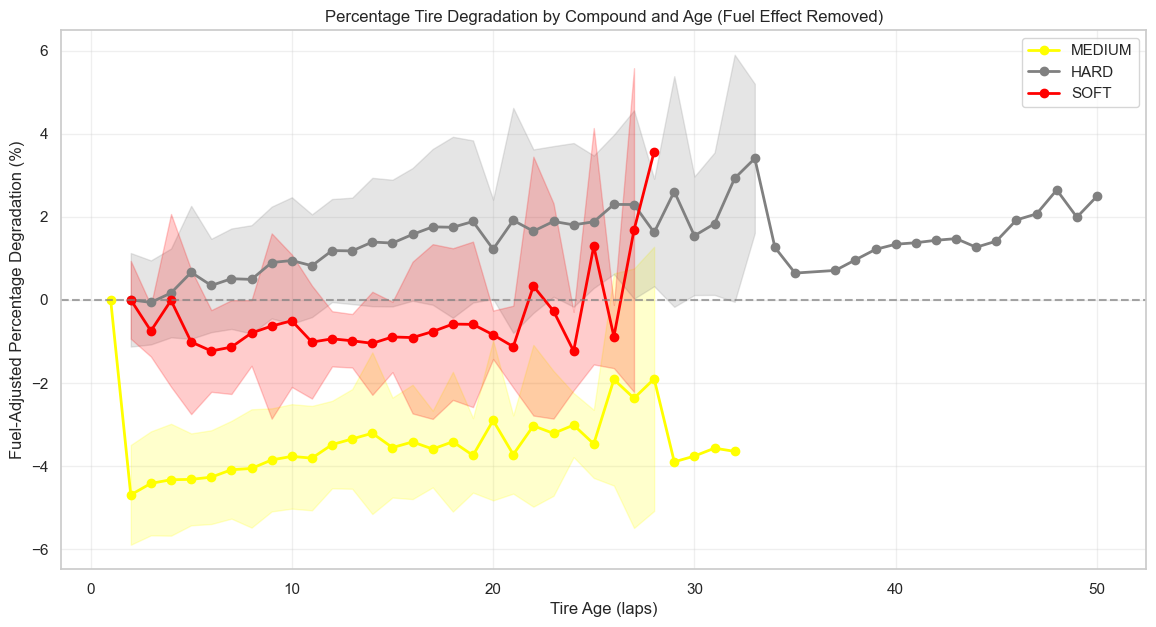

In [17]:
# Visualize the fuel-adjusted percentage degradation
plt.figure(figsize=(14, 7))

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Aggregate data for line plot
    agg_data = compound_subset.groupby('TyreAge')['FuelAdjustedDegPercent'].agg(['mean', 'std']).reset_index()
    
    # Plot mean line
    plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')
    
    # Add error bands if we have standard deviation
    if 'std' in agg_data.columns and not agg_data['std'].isnull().all():
        plt.fill_between(agg_data['TyreAge'], 
                        agg_data['mean'] - agg_data['std'], 
                        agg_data['mean'] + agg_data['std'],
                        color=color, alpha=0.2)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Fuel-Adjusted Percentage Degradation (%)')
plt.title('Percentage Tire Degradation by Compound and Age (Fuel Effect Removed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/fuel_adjusted_deg_percent_by_compound.png')
plt.show()

---

### 8.3 Tire Degradation Rate

In [18]:
# After plotting, add the variable to the dataframe
for compound_id in compound_ids:
    # Recalculate using the same method as in the visualization
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    avg_laptimes = compound_subset.groupby('TyreAge')['FuelAdjustedLapTime'].mean()
    deg_rates = avg_laptimes.diff()
    
    # Assign values to the dataframe
    for age, rate in zip(deg_rates.index, deg_rates.values):
        mask = (tire_deg_data['CompoundID'] == compound_id) & (tire_deg_data['TyreAge'] == age)
        tire_deg_data.loc[mask, 'DegradationRate'] = rate

# Verify that it has been added correctly
print("\nFirst rows with DegradationRate:")
display(tire_deg_data[['CompoundID', 'TyreAge', 'FuelAdjustedLapTime', 'DegradationRate']].head(10))



First rows with DegradationRate:


,CompoundID,TyreAge,FuelAdjustedLapTime,DegradationRate
0,2,1.0,83.935,NaN
798,2,2.0,79.401,-3.941625
863,2,2.0,78.967,-3.941625
737,2,2.0,78.734,-3.941625
918,2,2.0,79.825,-3.941625
669,2,2.0,79.196,-3.941625
533,2,2.0,79.492,-3.941625
965,2,2.0,79.760,-3.941625
401,2,2.0,80.578,-3.941625
219,2,2.0,80.220,-3.941625


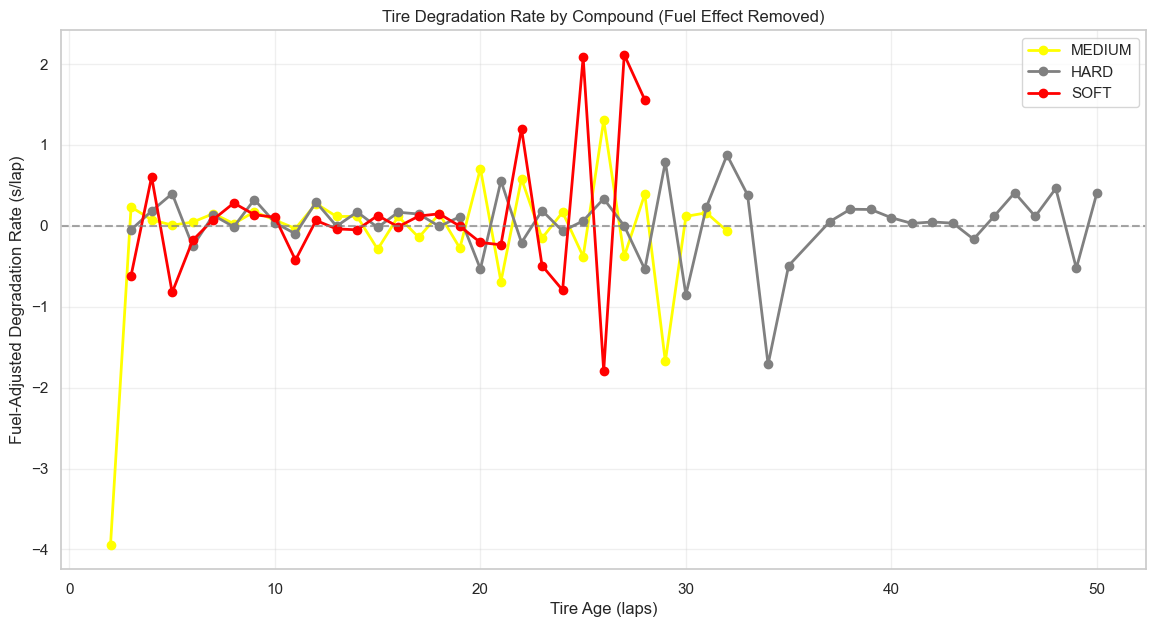

In [19]:
# Plot a line chart showing Tire Degradation Rate by compound with error bands
plt.figure(figsize=(14, 7))

for compound_id in compound_ids:
    # Filter the data for the current compound
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    
    # Calculate the average and standard deviation of degradation rate per tire age
    deg_stats = compound_subset.groupby('TyreAge')['DegradationRate'].agg(['mean', 'std']).reset_index()
    
    # Get color and compound name for the plot
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Plot the line for this compound
    plt.plot(deg_stats['TyreAge'], deg_stats['mean'], marker='o', linestyle='-',
             color=color, linewidth=2, label=compound_name)
    
    # Add error bands (standard deviation)
    # Check if we have valid standard deviation values
    if 'std' in deg_stats.columns and not deg_stats['std'].isnull().all():
        plt.fill_between(deg_stats['TyreAge'], 
                        deg_stats['mean'] - deg_stats['std'], 
                        deg_stats['mean'] + deg_stats['std'],
                        color=color, alpha=0.)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Fuel-Adjusted Degradation Rate (s/lap)')
plt.title('Tire Degradation Rate by Compound (Fuel Effect Removed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Fixing NaNs. This are due to diff pandas method. Assume 0 as new tires do not have degradation still

num_nans = tire_deg_data['DegradationRate'].isna().sum()
print(num_nans)

tire_deg_data['DegradationRate'] = tire_deg_data['DegradationRate'].fillna(0)
print(f"Number of NaN after sustitution: {tire_deg_data['DegradationRate'].isna().sum()}")

28
Number of NaN after sustitution: 0


## Key Findings

#### Medium Tire (Yellow).

- The fuel effect was masking significantly degradation. With the adjustment, mroe degradation can be seen.

- They offer the best initial advantage (-4 seconds), that stabilizes in -3 seconds until aproximately lap 30.

- Total fuel impact is about 1.73 seconds faster at the end of the stint.

- They represent the best balance between performance and durability.

#### Hard Tire (Gray)

- Fuel effect made an stabilization ilusion and even improvement. The adjust reveals a constant and progressive degradation that goes up to +2seconds.

- Fuel effect on this tires are the biggest, with 2.64 fastet.

- Degradation rate is more stable and predictable, making them ideal for long stints.

#### Soft Tire (Red)

- There is a bigger volatile effect that it seemed without fuel effect.
- Erratic behaviour and big fluctuations after lap 20.
- Highly unpredictable and dramatically fluctating, specially after lap 20, with extreme degradation peaks of +2 seconds slower per lap.

### Detected Turning Points

- *SOFT*: show a cliff degradation over 20 laps.
- *MEDIUM*: change in pattern near lap 30.
- *HARD*: show a degradation increase after lap 40.


### Good Conclussions for predictive model. 

1. Fuel adjustment was essential for identifying true degradation.
2. Each compound shows unique patterns that can be useful for the model:
    - Soft tire as high volatile with critic points of sudden degradation.
    - Medium tire has a fast fall followed by stabilization.
    - Hard tire with slow but continous degradation.

3. Identified turning points are going to be crucial parameters for the LSTM or XgBoost, as they show critic moments for pit stop strategies.

---

## 9. Correlation Analysis: Tire-Related Factors with Lap Time

In [21]:
# Invert dictionary to apply conversion to compound names to numbers 
compound_names_inv = {value: key for key, value in compound_names.items()}
# Replace the names with its according numbers
tire_deg_data["CompoundName"] = tire_deg_data["CompoundName"].replace(compound_names_inv)

# We can eliminate this column as it does not provide any information
tire_deg_data = tire_deg_data.drop('Unnamed: 0', axis=1)


C:\Users\victo\AppData\Local\Temp\ipykernel_10500\1821325703.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tire_deg_data["CompoundName"] = tire_deg_data["CompoundName"].replace(compound_names_inv)


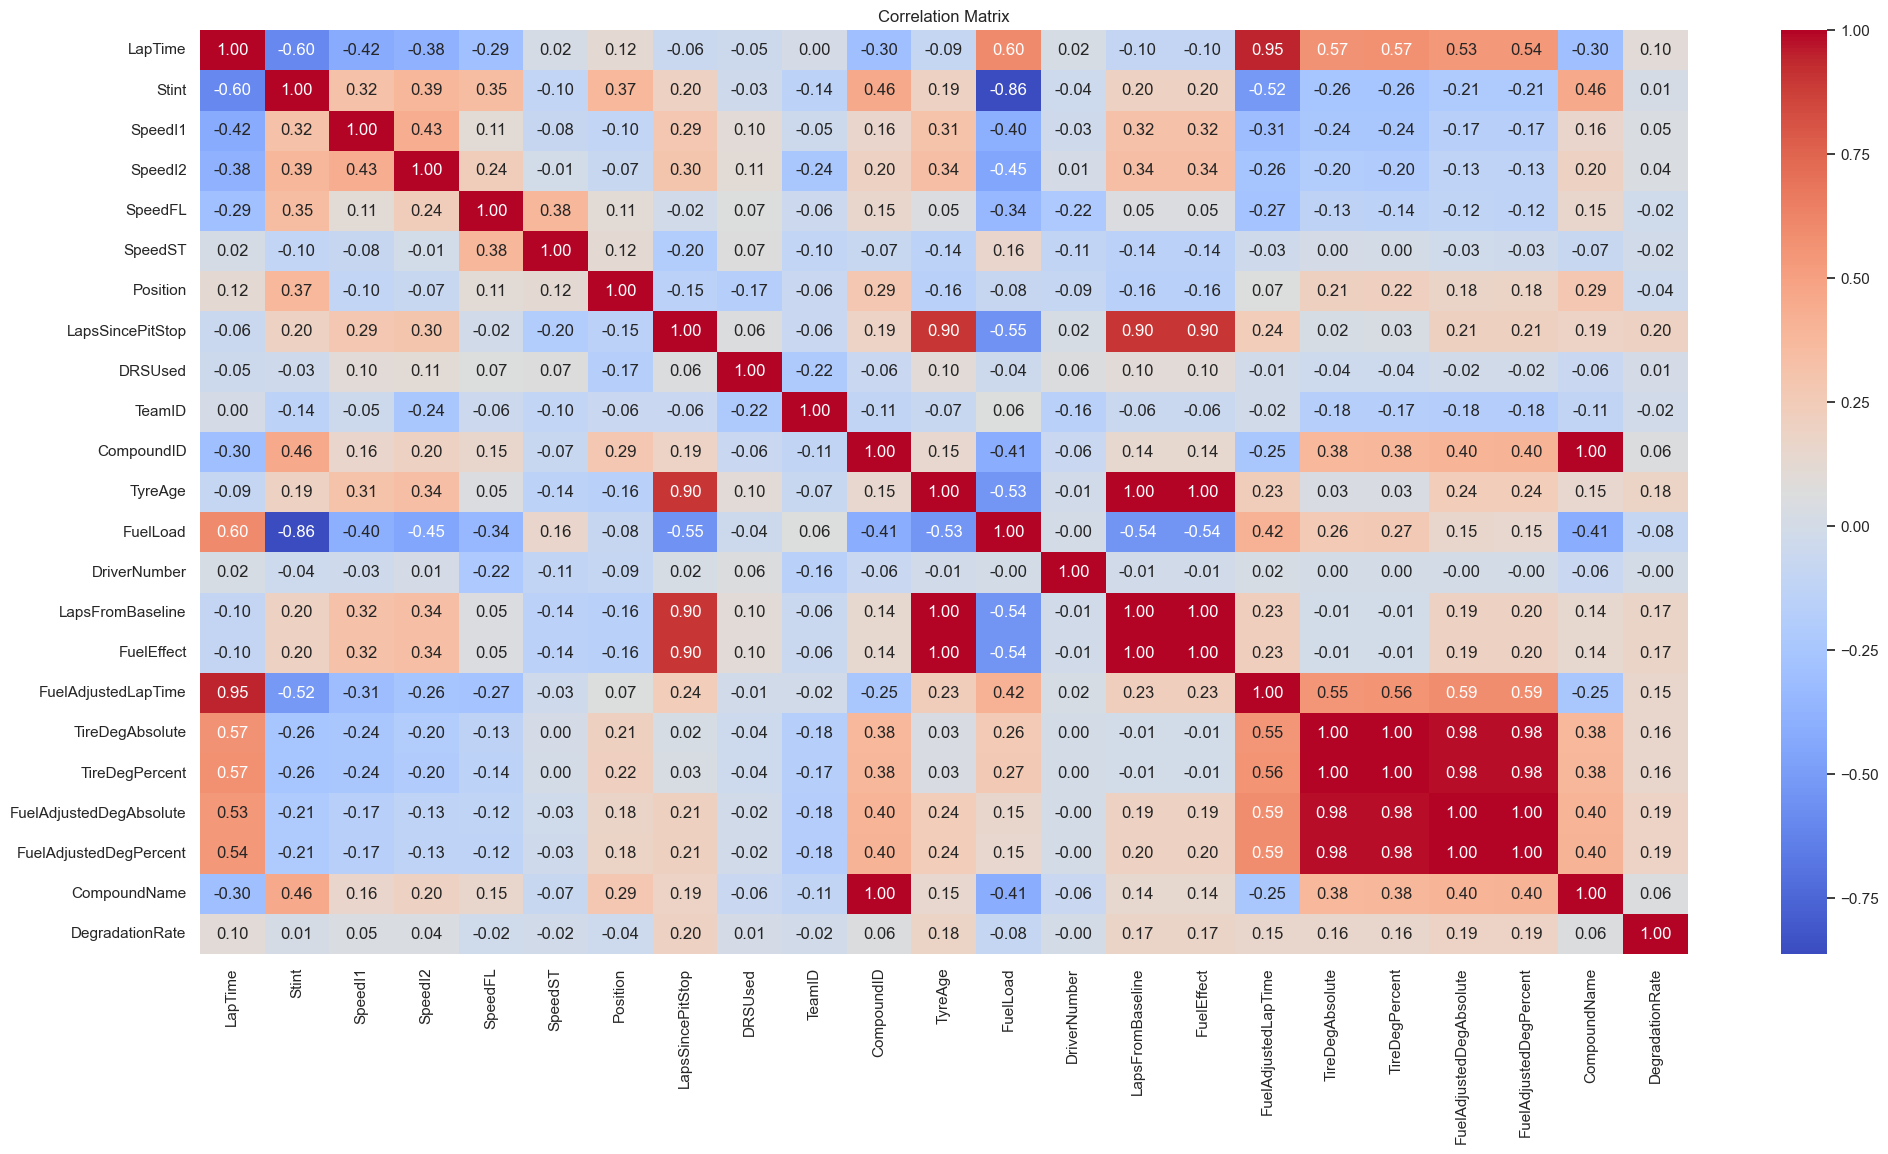

In [22]:
# Making correlation matrix
correlation_matrix = tire_deg_data.corr()


# Crear un heatmap
plt.figure(figsize=(24,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---

## 10. Conclussions and Variable Cleaning

**Variables to Keep**  
- **FuelAdjustedLapTime** (remove `LapTime`, correlation 0.95)  
  - Main lap time metric adjusted without the misleading fuel effect  
- **FuelAdjustedDegPercent** (remove other degradation metrics)  
  - Best metric for comparing compounds  
  - The four degradation metrics have very high correlations with each other (0.98–1.00). The pther 3 variables were only created to add more explicability to the data analysis.
- **DegradationRate**  
  - Captures the changing dynamics of degradation  
  - Its low correlation with other variables confirms it adds unique information  
  - Crucial for detecting inflection points and sudden changes  
- **TyreAge**  
  - A fundamental variable for the model  
  - Tire age is the main predictor of its condition  
- **CompoundID** (remove `CompoundName`)  
  - Needed to distinguish between different compounds  

- **Rest of variables**

**Optional Variables (if they improve the model)**  
- **SpeedI1**, **SpeedI2**, **SpeedFL**: to capture sector effects  
- **FuelLoad**: as a control variable  

**Variables to Remove**  
- **LapTime** (use only `FuelAdjustedLapTime`)  
- **TireDegAbsolute**, **TireDegPercent**, **FuelAdjustedDegAbsolute**  
- **CompoundName** (redundant with `CompoundID`)  
- **LapsFromBaseline** and **FuelEffect** (perfect correlation)  

In [23]:
# Remove only the specified redundant variables
columns_to_remove = [
    'LapTime',                 # Use only FuelAdjustedLapTime
    'TireDegAbsolute',         # Redundant with FuelAdjustedDegPercent
    'TireDegPercent',          # Redundant with FuelAdjustedDegPercent
    'FuelAdjustedDegAbsolute', # Redundant with FuelAdjustedDegPercent
    'CompoundName',            # Redundant with CompoundID
    'LapsFromBaseline',        # Perfect correlation
    'FuelEffect'               # Perfect correlation
]

# Drop columns from the dataframe
tire_deg_data = tire_deg_data.drop(columns=columns_to_remove)

# Show how many variables were removed and display a new correlation matrix
print(f"Removed {len(columns_to_remove)} redundant variables.")
print(f"The dataframe now has {tire_deg_data.shape[1]} columns.")




Removed 7 redundant variables.
The dataframe now has 16 columns.


---

## 11. New Correlation Matrix to see interesting Variables

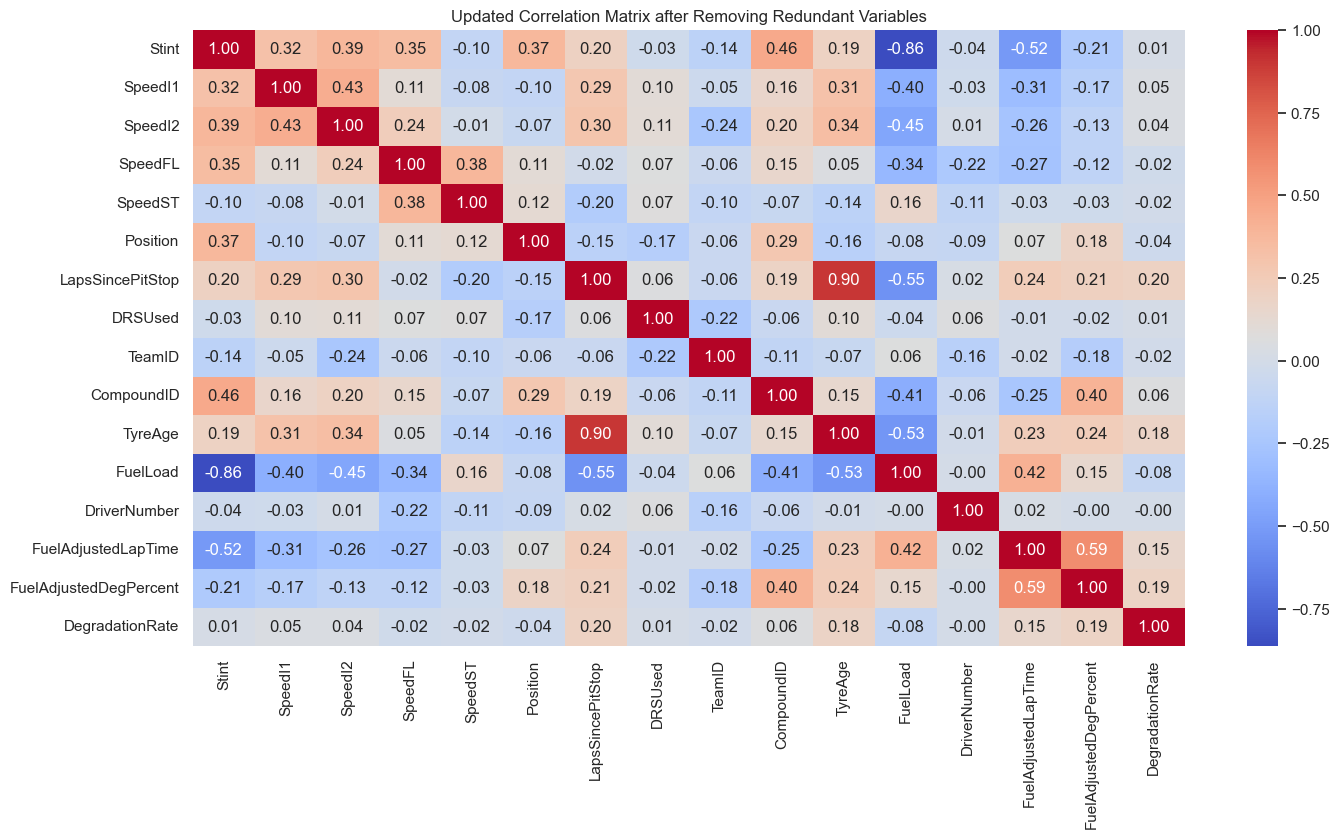

In [24]:
# Display the new correlation matrix
updated_correlation_matrix = tire_deg_data.corr()
plt.figure(figsize=(16,8))
sns.heatmap(updated_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Updated Correlation Matrix after Removing Redundant Variables")
plt.show()

After processing the data and applying fuel adjustment, the correlation matrix reveals critical relationships that will inform our LSTM model. Here are the main points:

- **Key Correlations:**
  - **FuelAdjustedLapTime & FuelAdjustedDegPercent:** Strong correlation (0.59) indicates similar degradation dynamics from different perspectives.
  - **TyreAge & LapsSincePitStop:** Almost perfect correlation (0.90), as both track similar information.
  - **CompoundID & FuelAdjustedDegPercent:** Moderate correlation (0.40) shows that tire compound significantly influences degradation.
  - **FuelLoad & Performance Metrics:** Strong negative correlation with Stint (-0.86) and moderate correlation with adjusted lap time (0.42), emphasizing the importance of fuel weight.
  - **DegradationRate:** Low correlation with most variables, including FuelAdjustedDegPercent (0.19), suggesting it captures unique degradation dynamics.

- **LSTM Model Input Selection:**
  - **Primary Variables:**
    - **FuelAdjustedLapTime:** Core performance metric without fuel effects.
    - **FuelAdjustedDegPercent:** Best metric for comparing compound performance.
    - **DegradationRate:** Captures lap-to-lap changes and critical inflection points.
    - **TyreAge:** Fundamental predictor of tire condition.
    - **CompoundID:** Essential for distinguishing between different tire compounds.
  - **Supporting Variables:**
    - **Speed Metrics (SpeedI1, SpeedI2, SpeedFL):** Capture sector-specific effects.
    - **FuelLoad:** Used as a control variable.
    - **Position:** Provides contextual race information.

---

## 12. Saving my final Dataframe as a CSV

In [25]:

# Guardar el DataFrame procesado con las métricas de degradación ajustadas por combustible
output_path = "../../outputs/week5/tire_degradation_fuel_adjusted.csv"

# Guardar el DataFrame
tire_deg_data.to_csv(output_path, index=False)

---


## 13. Creating Sequential Data

In [26]:
df = pd.read_csv("../../outputs/week5/tire_degradation_fuel_adjusted.csv")

## Sequencing Process for LSTM

### Creating Temporal Sequences:
- We need to transform our tabular data into chronologically ordered sequences.
- Each sequence should contain a sliding window of N consecutive laps (typically 5 laps).

### Data Format for LSTM:
**Input:** [lap_t-5, lap_t-4, lap_t-3, lap_t-2, lap_t-1]  

**Output:** [lap_t, lap_t+1, lap_t+2]

### Variables to Include in Each Sequence Element:
- FuelAdjustedLapTime
- FuelAdjustedDegPercent
- DegradationRate
- TyreAge
- CompoundID
- Contextual variables (FuelLoad, position, sector speeds)

It is crucial to ensure that the sequences maintain temporal integrity and do not mix data from different stints or pit stops.

In [27]:
def create_sequences(df, input_length=5, prediction_horizon=3, target_column='DegradationRate'):
    """
    Create sequences for any sequential model (LSTM, TCN) from the tire degradation data.
    Groups by driver, stint and compound to ensure proper sequencing.
    
    Args:
        df: DataFrame with tire degradation data
        input_length: Number of consecutive laps to include in input sequence
        prediction_horizon: Number of future laps to predict
        target_column: Column to predict
        
    Returns:
        sequences: List of DataFrame sequences
        targets: List of target arrays
    """
    sequences = []
    targets = []
    
    # Group by DriverNumber, Stint, and CompoundID
    groupby_columns = ['DriverNumber', 'Stint', 'CompoundID']
    
    # Process each driver-stint-compound group separately
    for name, group in df.groupby(groupby_columns):
        # Sort by TyreAge to ensure chronological order
        sorted_group = group.sort_values('TyreAge').reset_index(drop=True)
        
        # Skip if we don't have enough laps for a sequence
        if len(sorted_group) < input_length + prediction_horizon:
            continue
        
        # Create sliding window sequences
        for i in range(len(sorted_group) - input_length - prediction_horizon + 1):
            # Get input sequence (all features)
            seq = sorted_group.iloc[i:i+input_length]
            
            # Get target values (future values to predict)
            target = sorted_group.iloc[i+input_length:i+input_length+prediction_horizon][target_column].values
            
            sequences.append(seq)
            targets.append(target)
    
    print(f"Created {len(sequences)} sequences of {input_length} laps each")
    return sequences, targets



In [28]:
sequences, targets = create_sequences(df)

Created 763 sequences of 5 laps each


---

### Explanation of Sequences and Targets
#### What does the `create_sequences` function do?
The function creates data in a sequential format, necessary for training LSTM models. Specifically:

**Sequences:**
- They are "sliding windows" of consecutive data from the same set of tires.
- Each sequence contains data from 5 consecutive laps (all DataFrame columns).
- They represent the "recent history" that the model will use to make predictions.

**Targets:**
- These are the values we want to predict in the future.
- Each target contains the degradation values for the next 3 laps after the sequence.
- It only includes the column we want to predict (`FuelAdjustedDegPercent`).

#### Concrete Example
Imagine we have data from 10 laps with the same tire:

- **Sequence 1:** Laps 1-5
  - **Target 1:** Degradation in laps 6-8
- **Sequence 2:** Laps 2-6
  - **Target 2:** Degradation in laps 7-9
- **Sequence 3:** Laps 3-7
  - **Target 3:** Degradation in laps 8-10




---

### 13.1 New Approach: Divide sequences by compound ID

A good approach to try to improve the performance of our predictions is divide the data sequences by different tire compounds. In that way, I can try to develop 3 different models, each for every compound ID, alongside a global model. 

Like this, I can make the predictions using the specific model for that tire, compare it with the global prediction and try to do an emsemble between the two ones for improving robustness of the predictions


In [29]:
# Divide sequences by compound tire
def split_by_compound(df, sequences, targets):
    """
    Divide sequences and targets per compound ID
    
    """
    # Identify unique tire id
    compounds = df['CompoundID'].unique()
    
    # Create dictionaries for storing sequences per compound
    compound_sequences = {c: [] for c in compounds}
    compound_targets = {c: [] for c in compounds}
    
    # Assign each sequence to the corresponend dictionary
    for i, seq in enumerate(sequences):
        compound = seq['CompoundID'].iloc[0]
        compound_sequences[compound].append(seq)
        compound_targets[compound].append(targets[i])
    
    # Informar sobre la distribución de secuencias
    for compound in compounds:
        compound_name = compound_names.get(compound, f"Compound {compound}")
        print(f"{compound_name}: {len(compound_sequences[compound])} sequences")
    
    return compound_sequences, compound_targets, compounds

In [30]:
# Divide data per compound
compound_sequences, compound_targets, unique_compounds = split_by_compound(df, sequences, targets)

MEDIUM: 263 sequences
HARD: 356 sequences
SOFT: 144 sequences


---

## 14. Verifying the Sequential Data

In [31]:
def verify_sequences_with_targets(sequences, targets, num_to_check=3):
    print("COMPLETE SEQUENCE VERIFICATION (WITH TARGETS):")
    print("=============================================")
    
    # Check a few consecutive sequences from the same group
    driver_stint_compounds = []
    
    for i, seq in enumerate(sequences):
        # Get identifier for this sequence
        identifier = (seq['DriverNumber'].iloc[0], seq['Stint'].iloc[0], seq['CompoundID'].iloc[0])
        driver_stint_compounds.append(identifier)
    
    # Find groups with consecutive sequences
    for i in range(len(sequences)-1):
        # Check if consecutive sequences are from same driver-stint-compound
        if driver_stint_compounds[i] == driver_stint_compounds[i+1]:
            seq1 = sequences[i]
            seq2 = sequences[i+1]
            
            # Get tire ages and targets
            ages1 = seq1['TyreAge'].values
            ages2 = seq2['TyreAge'].values
            target1 = targets[i]
            target2 = targets[i+1]
            
            # Calculate what the next tire ages should be (for targets)
            expected_target_ages1 = np.array([ages1[-1] + j + 1 for j in range(len(target1))])
            expected_target_ages2 = np.array([ages2[-1] + j + 1 for j in range(len(target2))])
            
            # Check if sliding window pattern is correct
            sliding_window_correct = np.array_equal(ages1[1:], ages2[:-1])
            
            # Print results
            print(f"\nSequences {i} and {i+1}:")
            print(f"Driver: {seq1['DriverNumber'].iloc[0]}, Stint: {seq1['Stint'].iloc[0]}, Compound: {seq1['CompoundID'].iloc[0]}")
            print(f"Tire ages seq {i}: {ages1}")
            print(f"TARGET values seq {i}: {target1}")
            print(f"Expected target ages seq {i}: {expected_target_ages1}")
            print(f"Tire ages seq {i+1}: {ages2}")
            print(f"TARGET values seq {i+1}: {target2}")
            print(f"Expected target ages seq {i+1}: {expected_target_ages2}")
            print(f"Sliding window pattern: {sliding_window_correct}")
            
            # Verify that target1 corresponds to the next values after seq1
            # We'd need the original dataframe to check this precisely
            
            # Only check a limited number
            num_to_check -= 1
            if num_to_check <= 0:
                break
    
    print("\nVERIFICATION SUMMARY:")
    print("1. Each sequence should advance by one lap (sliding window pattern)")
    print("2. Targets should contain the FuelAdjustedDegPercent values for the next 3 laps")
    print("3. Each target should start exactly where its sequence ends")

In [32]:
# Verirfy sequences with their targets
verify_sequences_with_targets(sequences, targets)

COMPLETE SEQUENCE VERIFICATION (WITH TARGETS):

Sequences 0 and 1:
Driver: 1, Stint: 1.0, Compound: 2
Tire ages seq 0: [1. 2. 3. 4. 5.]
TARGET values seq 0: [0.04476471 0.14976471 0.02611765]
Expected target ages seq 0: [6. 7. 8.]
Tire ages seq 1: [2. 3. 4. 5. 6.]
TARGET values seq 1: [0.14976471 0.02611765 0.17282353]
Expected target ages seq 1: [7. 8. 9.]
Sliding window pattern: True

Sequences 1 and 2:
Driver: 1, Stint: 1.0, Compound: 2
Tire ages seq 1: [2. 3. 4. 5. 6.]
TARGET values seq 1: [0.14976471 0.02611765 0.17282353]
Expected target ages seq 1: [7. 8. 9.]
Tire ages seq 2: [3. 4. 5. 6. 7.]
TARGET values seq 2: [0.02611765 0.17282353 0.07052941]
Expected target ages seq 2: [ 8.  9. 10.]
Sliding window pattern: True

Sequences 2 and 3:
Driver: 1, Stint: 1.0, Compound: 2
Tire ages seq 2: [3. 4. 5. 6. 7.]
TARGET values seq 2: [0.02611765 0.17282353 0.07052941]
Expected target ages seq 2: [ 8.  9. 10.]
Tire ages seq 3: [4. 5. 6. 7. 8.]
TARGET values seq 3: [ 0.17282353  0.07052941

### Validation of Data Sequencing
#### Sliding Window Pattern:
- Each sequence advances exactly one lap relative to the previous one.
- Example: `[1,2,3,4,5] → [2,3,4,5,6] → [3,4,5,6,7] → [4,5,6,7,8]`

#### Consistency in Targets:
- Targets always represent the next 3 laps after each sequence.
- Example: Sequence 0 ends at lap 5, targets are laps 6, 7, 8.

#### Coherence Between Sequences and Targets:
- The target values also "slide" accordingly:
  - **Target of Sequence 0:** `[-3.88, -3.73, -4.36]`
  - **Target of Sequence 1:** `[-3.73, -4.36, -3.83]`
- The first two values of Target 1 match the last two of Target 0.

#### Maintaining Structure by Driver, Stint, and Compound:
- All shown sequences belong to the same driver (1), same stint (1.0), and same compound (2).
- This ensures we are analyzing the degradation of a single set of tires.

### Implications for Our LSTM Model
- The model can learn degradation patterns based on consecutive lap sequences.
- It can predict degradation for the next 3 laps using the previous 5 laps.
- The data structure captures both the absolute degradation level and its rate of change.

With this verification, we confirm that the data is correctly prepared for training the LSTM model. We have selected `FuelAdjustedDegPercent` as our target, which is appropriate since it represents degradation adjusted for fuel effects, precisely what we aim to predict

---

## 15 LSTM: Data Preparation

In [33]:
def prepare_for_lstm(sequences, targets):
    """
    Convert the list of DataFrames and targets into numpy arrays suitable for LSTM training
    """
    # Get the number of features (columns) in the sequence DataFrames
    n_features = len(sequences[0].columns)
    sequence_length = len(sequences[0])
    prediction_horizon = len(targets[0])
    
    # Initialize arrays
    X = np.zeros((len(sequences), sequence_length, n_features))
    y = np.zeros((len(sequences), prediction_horizon))
    
    # Fill the arrays
    for i, (seq, target) in enumerate(zip(sequences, targets)):
        X[i] = seq.values
        y[i] = target
    
    print(f"Prepared data for LSTM with shape: X: {X.shape}, y: {y.shape}")
    return X, y


In [34]:
# Prepare data for LSTM (convert to numpy arrays)
X, y = prepare_for_lstm(sequences, targets)

Prepared data for LSTM with shape: X: (763, 5, 16), y: (763, 3)


### 15.1 **Prepared Data:**
- **X**: (763, 5, 16) → 763 sequences, each containing 5 laps and 16 features per lap
- **y**: (763, 3) → For each sequence, we predict 3 future laps of degradation

---

### 15.2 **Dataset Split:**

In [35]:
# Split data into train, validation and test sets (70-15-15)
# First split: separate test set (15%)
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Second split: divide remaining data into train (70%) and validation (15%)
# The validation should be 17.65% of the temporary set (0.15/0.85)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42
)

---

In [36]:
# Print the shapes of the resulting datasets
print("Data split:")
print(f"X_train shape: {X_train.shape} ({len(X_train)/len(X):.1%})")
print(f"X_val shape: {X_val.shape} ({len(X_val)/len(X):.1%})")
print(f"X_test shape: {X_test.shape} ({len(X_test)/len(X):.1%})")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

Data split:
X_train shape: (533, 5, 16) (69.9%)
X_val shape: (115, 5, 16) (15.1%)
X_test shape: (115, 5, 16) (15.1%)
y_train shape: (533, 3)
y_val shape: (115, 3)
y_test shape: (115, 3)


- **Train**: 533 sequences (69.9%) - very close to the 70% target
- **Validation**: 115 sequences (15.1%) - very close to the 15% target
- **Test**: 115 sequences (15.1%) - very close to the 15% target

---

## 16. Pytorch Data Preparation

### 16.1 Creating Tensors

In [37]:
# Train
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
# Validation
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
# Test
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)



### 16.2 Creating Datasets 

In [38]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


### 16.3 Creating Dataloaders

In [39]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### 16.3 Prepare Data by Compound

In [40]:
def prepare_compound_data(compound_sequences, compound_targets):
    """
    
    Prepare data of each compound for the model
    
    """
    
    compound_data = {}
    
    for compound in unique_compounds:
        if len(compound_sequences[compound]) > 0:
            # Convert sequences to numpy format
            X, y = prepare_for_lstm(compound_sequences[compound], compound_targets[compound])
            compound_data[compound] = (X, y)
            
            print(f"Compound {compound_names.get(compound, compound)}: X shape {X.shape}, y shape {y.shape}")
    
    return compound_data



In [41]:
# Prepare specific data for each tire
compound_data = prepare_compound_data(compound_sequences, compound_targets)

Prepared data for LSTM with shape: X: (263, 5, 16), y: (263, 3)
Compound MEDIUM: X shape (263, 5, 16), y shape (263, 3)
Prepared data for LSTM with shape: X: (356, 5, 16), y: (356, 3)
Compound HARD: X shape (356, 5, 16), y shape (356, 3)
Prepared data for LSTM with shape: X: (144, 5, 16), y: (144, 3)
Compound SOFT: X shape (144, 5, 16), y shape (144, 3)


---

## 17. LSTM Architecture: Changed to Temporal Convolutional Network

In [42]:
# class TireDegradationLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout = 0.3):
#         super(TireDegradationLSTM, self).__init__()

#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         # LSTM Layer for Capturing sequential patterns
#         # RUN 2 : Bidirectional lstm for camputiring more patterns

#         self.lstm = nn.LSTM(
#             input_size= input_size,
#             hidden_size= hidden_size,
#             num_layers=num_layers,
#             batch_first= True,
#             dropout= dropout if num_layers > 1 else 0 ,
#             bidirectional= True # With this parameter it becomes bidirecional

#         )

#         # Layer normalization for stabilizing training
#         self.layer_norm1 = nn.LayerNorm(hidden_size * 2)  # *2 because it is bidirectional
        
#         # RUN 2: deeper dense layer system with redidual conections
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
#         self.layer_norm2 = nn.LayerNorm(hidden_size)
#         self.dropout1 = nn.Dropout(dropout)
        
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.layer_norm3 = nn.LayerNorm(hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout)
        
#         self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
#         # Activations
#         self.relu = nn.ReLU()

#     def forward(self, x):

#         # x shape must be (batch_size, sequence_length, input_size)

#         # LSTM output
#         lstm_out, _ = self.lstm(x)

#         # Use only last time step output
#         lstm_out = lstm_out[:, -1, :]

#         # RUN 2 Normalization and First FC layer
#         lstm_out = self.layer_norm1(lstm_out)

#         # First dense layer with normalization and residual
#         out = self.fc1(lstm_out)
#         out = self.layer_norm2(out)
#         out = self.relu(out)
#         out = self.dropout1(out)

#         # Second dense layer
#         residual = out  # We store it for residual conection
#         out = self.fc2(out)
#         out = self.layer_norm3(out)
#         out = self.relu(out)
#         out = self.dropout2(out)

#         # Output layer

#         out = self.fc3(out)
        

#         return out

In [43]:
import torch.nn.functional as F

In [44]:
class EnhancedTCN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, dropout=0.3):
        super(EnhancedTCN, self).__init__()
        
        # 1. Increase capacity and add regularization
        # Project the input to a higher-dimensional space using a 1D convolution.
        self.input_proj = nn.Conv1d(input_size, hidden_size, kernel_size=1)
        # Batch normalization on the projected input.
        self.bn_input = nn.BatchNorm1d(hidden_size)
        
        # 2. Multi-Scale Block with Exponential Dilations
        # Residual layers with different dilation rates to capture multi-scale patterns.
        # First dilated convolution with dilation=1.
        self.dilated_conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding='same', dilation=1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        # Second dilated convolution with dilation=2.
        self.dilated_conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding='same', dilation=2)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        # Third dilated convolution with dilation=4.
        self.dilated_conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding='same', dilation=4)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        # Fourth dilated convolution with dilation=8.
        self.dilated_conv8 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding='same', dilation=8)
        self.bn8 = nn.BatchNorm1d(hidden_size)
        
        # 3. Simple Temporal Attention Mechanism
        # Use a 1D convolution to compute attention scores over the sequence.
        self.attention = nn.Conv1d(hidden_size, 1, kernel_size=1)
        # Softmax is applied along the time dimension (seq_len).
        self.softmax = nn.Softmax(dim=2)
        
        # 4. Output Layer with Higher Dropout for Regularization
        self.dropout = nn.Dropout(dropout)
        # Fully connected layers for final prediction.
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
    def forward(self, x):
        # x: [batch_size, seq_len, features]
        # Transpose the input to [batch, features, seq_len] for Conv1d operations.
        x = x.transpose(1, 2)
        
        # Initial projection: apply convolution, batch norm and ReLU activation.
        x = F.relu(self.bn_input(self.input_proj(x)))
        
        # Apply dilated convolutions with residual connections.
        # First residual block with dilation=1.
        residual = x
        x = F.relu(self.bn1(self.dilated_conv1(x)))
        x = x + residual  # Residual connection
        
        # Second residual block with dilation=2.
        residual = x
        x = F.relu(self.bn2(self.dilated_conv2(x)))
        x = x + residual  # Residual connection
        
        # Third residual block with dilation=4.
        residual = x
        x = F.relu(self.bn4(self.dilated_conv4(x)))
        x = x + residual  # Residual connection
        
        # Fourth residual block with dilation=8.
        residual = x
        x = F.relu(self.bn8(self.dilated_conv8(x)))
        x = x + residual  # Residual connection
        
        # Apply the attention mechanism.
        # Compute attention weights for each time step.
        attn_weights = self.softmax(self.attention(x))  # Shape: [batch, 1, seq_len]
        # Multiply feature maps with the attention weights.
        x = x * attn_weights
        
        # Global pooling: sum over the time dimension.
        x = torch.sum(x, dim=2)  # Resulting shape: [batch, channels]
        x = self.dropout(x)
        
        # Pass through fully connected layers with dropout and ReLU activations.
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


---

### 17.1. Hyperparameters


In [45]:
# ################################ HYPERPARAMETER DEFINITION #######################################

# ### RUN 2 
# input_size = 16 # Number of features
# hidden_size = 128  # Hidden layer size: from 64 to 128
# num_layers = 3 # Number of LSTM layers: from 2 to 3
# output_size = 3 # Number of future laps to predict
# learning_rate = 0.0005 # Reduced from 0.001 for more stable training
# weight_decay = 1e-5  # Added l2 regularization


# num_epochs = 150 # From 100, more for allowing convergence with new architecture
# patience = 20 # Apply early stopping. If no improvements after 15 epochs, stop training. Augmented to 20 for more convergence


In [46]:
############################################### TCN HYPERPARAMETERS ##################################
input_size = 16
output_size = 3
learning_rate = 0.0001  # Lower learning rate
weight_decay = 1e-6
batch_size = 32
num_epochs = 200
patience = 25



#### 17.1.1. Hyperparameters for specific compound models

In [47]:
# Shorter training cicles for specific models
compound_epochs = 100  
compound_patience = 15

---

### 17.2 Initializing Model

In [48]:
######################################### LSTM ###################################
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")          #
# model = TireDegradationLSTM(input_size, hidden_size, num_layers, output_size)  #
# model.to(device)                                                               #
##################################################################################

In [49]:
####################################### TCN ######################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedTCN(input_size, output_size)
model.to(device)

EnhancedTCN(
  (input_proj): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
  (bn_input): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dilated_conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dilated_conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dilated_conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dilated_conv8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(8,))
  (bn8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  (softmax): Softmax(dim=2)
  (dropout): Dropout(p=0.3

---

### 17.3 Loss Function and Optimizer

In [50]:
#from torch.optim.lr_scheduler import ReduceLROnPlateau
# criterion = nn.MSELoss()
# # RUN 2: added L2 regularization
# optimizer = optim.Adam(model.parameters(), lr= learning_rate, weight_decay= weight_decay)

# #RUN 2 : learning rate programmer
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

In [51]:
########################### TCN #####################################


optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0005,  #  Initial higher learning rate
    weight_decay=1e-4  # Stronger regularization
)
# Scheduler with cicled warming
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,  # Initial 5 epoch cicling
    T_mult=2,  # Duplicate cicle in each restart
    eta_min=1e-6  # Minimum learning rate value
)
criterion = nn.MSELoss()

---

## 18. Training

### 18.1 Training Function for a single Epoch

#### 18.1.1 LSTM Train Epoch Commented

In [52]:
####################################### LSTM ####################################
# def train_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#
#         # Forward pass
#
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#
#         # Backpropagation and Optimization
#
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#
#        
#
#         running_loss += loss.item() * inputs.size(0)
#
#     epoch_loss = running_loss / len(train_loader.dataset)
#     return epoch_loss
####################################################################################

        

---

#### 18.1.2 Train Epoch for TCN

In [53]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backpropagation y optimización
        optimizer.zero_grad()
        loss.backward()
        # Añadir gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

### 18.1 Evaluation Function

In [54]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

    total_loss = running_loss / len(data_loader.dataset)
    return total_loss

---

## 19. Training with Early Stopping

#### 19.1 LSTM Training Loop

In [55]:
# best_val_loss = float("inf")
# counter = 0 # Counter for epochs without improvement
# train_losses = []
# val_losses = []


# print("Starting Training...")

# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
#     val_loss = evaluate(model, val_loader, criterion, device)


#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

#     # Check early stopping condition

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         counter = 0
#         # Store best model

#         torch.save(model.state_dict(), "../../outputs/week5/models/tire_degradation_lstm.pth")
#         print(f" Saving model (val_loss improved: {best_val_loss:.6f})")

#     else:
#         counter += 1
#         if counter >= patience:
#             print(f"Early stopping on epoch {epoch + 1}")
#             break

#### 19.2 TCN Training Loop

In [56]:
# Main loop with early stopping and proper model saving

# Initialize best validation loss as infinity for tracking improvement
best_val_loss = float('inf')
counter = 0  # Counter for early stopping
train_losses = []  # Store training loss per epoch
val_losses = []  # Store validation loss per epoch

print("Starting Training...")
for epoch in range(num_epochs):
    # Train for one epoch and get the training loss
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    # Evaluate on the validation set and get the validation loss
    val_loss = evaluate(model, val_loader, criterion, device)
    
    # Store losses for later analysis
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduler updates the LR based on validation loss
    scheduler.step(val_loss)
    
    # Print training progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Early stopping and model saving logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update best validation loss
        counter = 0  # Reset early stopping counter
        # Save the model in a DIFFERENT file than the LSTM model
        torch.save(model.state_dict(), '../../outputs/week5/models/tire_degradation_tcn.pth')
        print(f"Saving model (improved val_loss: {best_val_loss:.6f})")
    else:
        counter += 1  # Increment early stopping counter
        if counter >= patience:  # If no improvement for 'patience' epochs
            print(f"Early stopping at epoch {epoch+1}")
            break  # Stop training


Starting Training...
Epoch 1/200, Train Loss: 0.439643, Val Loss: 0.607218
Saving model (improved val_loss: 0.607218)
Epoch 2/200, Train Loss: 0.231659, Val Loss: 0.123929
Saving model (improved val_loss: 0.123929)
Epoch 3/200, Train Loss: 0.174726, Val Loss: 0.108516
Saving model (improved val_loss: 0.108516)
Epoch 4/200, Train Loss: 0.152484, Val Loss: 0.108125
Saving model (improved val_loss: 0.108125)
Epoch 5/200, Train Loss: 0.140625, Val Loss: 0.110146
Epoch 6/200, Train Loss: 0.137603, Val Loss: 0.108801
Epoch 7/200, Train Loss: 0.139411, Val Loss: 0.110746
Epoch 8/200, Train Loss: 0.138693, Val Loss: 0.112275
Epoch 9/200, Train Loss: 0.139683, Val Loss: 0.110762
Epoch 10/200, Train Loss: 0.137313, Val Loss: 0.109801
Epoch 11/200, Train Loss: 0.135822, Val Loss: 0.110769
Epoch 12/200, Train Loss: 0.134534, Val Loss: 0.110392
Epoch 13/200, Train Loss: 0.131911, Val Loss: 0.111831
Epoch 14/200, Train Loss: 0.135100, Val Loss: 0.114514
Epoch 15/200, Train Loss: 0.131940, Val Loss: 

### 19.3 Training models by Compound

In [57]:
# Cell 19.a: Function to train models for each compound
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_compound_model(compound_id, X, y, device):
    """Trains a specific model for a given compound"""
    
    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Create datasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    # Dataloaders
    compound_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    compound_val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    compound_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    compound_model = EnhancedTCN(input_size, output_size)
    compound_model.to(device)
    
    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(
        compound_model.parameters(), 
        lr=0.0005,
        weight_decay=1e-4
    )
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=5,  # Initial restart period (5 epochs)
        T_mult=2,  # Multiplier for increasing restart periods
        eta_min=1e-6  # Minimum learning rate
    )
    
    criterion = nn.MSELoss()  # Mean Squared Error Loss function
    
    # Training with early stopping
    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    counter = 0  # Early stopping counter
    train_losses = []  # Store training losses per epoch
    val_losses = []  # Store validation losses per epoch
    
    for epoch in range(compound_epochs):
        # Train for one epoch and compute training loss
        train_loss = train_epoch(compound_model, compound_train_loader, criterion, optimizer, device)
        # Evaluate on validation set and compute validation loss
        val_loss = evaluate(compound_model, compound_val_loader, criterion, device)
        
        # Store loss values
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Update learning rate scheduler
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{compound_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Early stopping and model saving logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            counter = 0  # Reset early stopping counter
            # Save the model with a unique filename per compound
            torch.save(compound_model.state_dict(), f'../../outputs/week5/models/tcn_compound_{compound_id}.pth')
            print(f"Saving model (improved val_loss: {best_val_loss:.6f})")
        else:
            counter += 1  # Increment early stopping counter
            if counter >= compound_patience:  # If no improvement for 'compound_patience' epochs
                print(f"Early stopping at epoch {epoch+1}")
                break  # Stop training early
    
    # Load the best model version before testing
    compound_model.load_state_dict(torch.load(f'../../outputs/week5/models/tcn_compound_{compound_id}.pth'))
    
    # Evaluate on test set
    test_loss = evaluate(compound_model, compound_test_loader, criterion, device)
    
    # Model evaluation metrics
    compound_model.eval()  # Set model to evaluation mode
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, targets in compound_test_loader:
            inputs = inputs.to(device)
            outputs = compound_model(inputs)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.numpy())
    
    if len(predictions) > 0:
        # Convert lists into arrays for metric calculation
        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)  # Root Mean Squared Error
        mae = mean_absolute_error(actuals, predictions)
        
        metrics = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae
        }
    else:
        # Handle case where no predictions are generated
        metrics = {'mse': float('nan'), 'rmse': float('nan'), 'mae': float('nan')}
    
    return compound_model, metrics, (train_losses, val_losses)


#### Training Loop per Compound

In [58]:
specialized_models = {}
compound_performance = {}
compound_loss_curves = {}

for compound in compound_data:
    compound_name = compound_names.get(compound, f"Compound {compound}")
    print(f"\n=== Training model for {compound_name} ===")
    
    X, y = compound_data[compound]
    
    # Only train if enough data
    if len(X) > 10:  
        model, metrics, loss_curves = train_compound_model(compound, X, y, device)
        
        specialized_models[compound] = model
        compound_performance[compound] = metrics
        compound_loss_curves[compound] = loss_curves
    else:
        print(f"Not enough data for {compound_name} tire")


=== Training model for MEDIUM ===
Epoch 1/100, Train Loss: 0.450493, Val Loss: 15.898336
Saving model (improved val_loss: 15.898336)
Epoch 2/100, Train Loss: 0.302535, Val Loss: 1.848228
Saving model (improved val_loss: 1.848228)
Epoch 3/100, Train Loss: 0.251949, Val Loss: 0.329314
Saving model (improved val_loss: 0.329314)
Epoch 4/100, Train Loss: 0.228091, Val Loss: 0.159844
Saving model (improved val_loss: 0.159844)
Epoch 5/100, Train Loss: 0.213843, Val Loss: 0.143892
Saving model (improved val_loss: 0.143892)
Epoch 6/100, Train Loss: 0.205361, Val Loss: 0.149722
Epoch 7/100, Train Loss: 0.154501, Val Loss: 0.153115
Epoch 8/100, Train Loss: 0.153621, Val Loss: 0.157040
Epoch 9/100, Train Loss: 0.145289, Val Loss: 0.161799
Epoch 10/100, Train Loss: 0.148804, Val Loss: 0.160671
Epoch 11/100, Train Loss: 0.134025, Val Loss: 0.157460
Epoch 12/100, Train Loss: 0.136052, Val Loss: 0.153936
Epoch 13/100, Train Loss: 0.132268, Val Loss: 0.152090
Epoch 14/100, Train Loss: 0.126630, Val Lo

C:\Users\victo\AppData\Local\Temp\ipykernel_10500\983853716.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  compound_model.load_state_dict(torch.load(f'../../outputs/we

Epoch 4/100, Train Loss: 0.130086, Val Loss: 0.119611
Saving model (improved val_loss: 0.119611)
Epoch 5/100, Train Loss: 0.122504, Val Loss: 0.112113
Saving model (improved val_loss: 0.112113)
Epoch 6/100, Train Loss: 0.118344, Val Loss: 0.105181
Saving model (improved val_loss: 0.105181)
Epoch 7/100, Train Loss: 0.095412, Val Loss: 0.103937
Saving model (improved val_loss: 0.103937)
Epoch 8/100, Train Loss: 0.093978, Val Loss: 0.102802
Saving model (improved val_loss: 0.102802)
Epoch 9/100, Train Loss: 0.087939, Val Loss: 0.102615
Saving model (improved val_loss: 0.102615)
Epoch 10/100, Train Loss: 0.085173, Val Loss: 0.102434
Saving model (improved val_loss: 0.102434)
Epoch 11/100, Train Loss: 0.091642, Val Loss: 0.102427
Saving model (improved val_loss: 0.102427)
Epoch 12/100, Train Loss: 0.081382, Val Loss: 0.102845
Epoch 13/100, Train Loss: 0.079541, Val Loss: 0.103202
Epoch 14/100, Train Loss: 0.082935, Val Loss: 0.103183
Epoch 15/100, Train Loss: 0.082558, Val Loss: 0.103190
Ep

C:\Users\victo\AppData\Local\Temp\ipykernel_10500\983853716.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  compound_model.load_state_dict(torch.load(f'../../outputs/we

Epoch 5/100, Train Loss: 0.341457, Val Loss: 0.108641
Saving model (improved val_loss: 0.108641)
Epoch 6/100, Train Loss: 0.371463, Val Loss: 0.098321
Saving model (improved val_loss: 0.098321)
Epoch 7/100, Train Loss: 0.389031, Val Loss: 0.097813
Saving model (improved val_loss: 0.097813)
Epoch 8/100, Train Loss: 0.352706, Val Loss: 0.095495
Saving model (improved val_loss: 0.095495)
Epoch 9/100, Train Loss: 0.346433, Val Loss: 0.095785
Epoch 10/100, Train Loss: 0.306359, Val Loss: 0.094745
Saving model (improved val_loss: 0.094745)
Epoch 11/100, Train Loss: 0.307905, Val Loss: 0.095800
Epoch 12/100, Train Loss: 0.331949, Val Loss: 0.096560
Epoch 13/100, Train Loss: 0.312106, Val Loss: 0.096629
Epoch 14/100, Train Loss: 0.329826, Val Loss: 0.096971
Epoch 15/100, Train Loss: 0.311415, Val Loss: 0.097683
Epoch 16/100, Train Loss: 0.337271, Val Loss: 0.096982
Epoch 17/100, Train Loss: 0.295769, Val Loss: 0.095299
Epoch 18/100, Train Loss: 0.286832, Val Loss: 0.095890
Epoch 19/100, Train 

C:\Users\victo\AppData\Local\Temp\ipykernel_10500\983853716.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  compound_model.load_state_dict(torch.load(f'../../outputs/we

#### Obtain Combined Learning Rates

In [59]:
# Extract learning curves for plotting
train_losses_combined = []
val_losses_combined = []

# Determine the maximum length among all learning curves
max_length = 0
for compound in compound_loss_curves:
    train_curve, val_curve = compound_loss_curves[compound]
    max_length = max(max_length, len(train_curve))

# Compute the average of the learning curves
for i in range(max_length):
    train_sum = 0
    val_sum = 0
    count = 0
    
    for compound in compound_loss_curves:
        train_curve, val_curve = compound_loss_curves[compound]
        if i < len(train_curve):
            train_sum += train_curve[i]
            val_sum += val_curve[i]
            count += 1
    
    if count > 0:
        train_losses_combined.append(train_sum / count)
        val_losses_combined.append(val_sum / count)

# Use these combined curves for plotting
train_losses = train_losses_combined
val_losses = val_losses_combined


---

## 20. Load Best Model

In [60]:
#model.load_state_dict(torch.load("../../outputs/week5/models/tire_degradation_lstm.pth"))
model.load_state_dict(torch.load('../../outputs/week5/models/tire_degradation_tcn.pth'))

C:\Users\victo\AppData\Local\Temp\ipykernel_10500\517774325.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../outputs/week5/models/

<All keys matched successfully>

---

## 21. Evaluating on test Set

In [61]:
test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.126593


In [62]:
## Making predictions on test set
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)


---

## 22. Calculating metrics

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)

In [64]:
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")

Test MSE: 0.126593
Test RMSE: 0.355799
Test MAE: 0.232302


### 22.1 Losses in training and validation

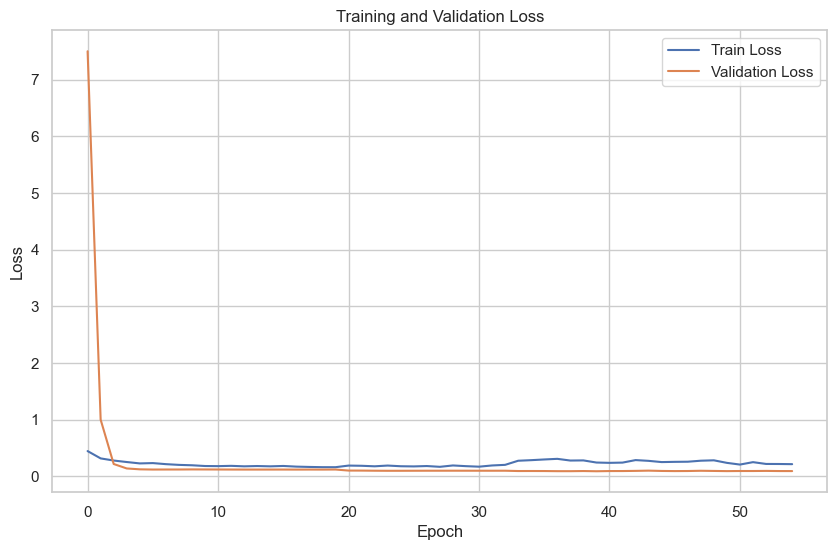

In [65]:
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('../../outputs/week5/training_validation_loss.png')
plt.show()

### 22.2 Predictions vs Real values

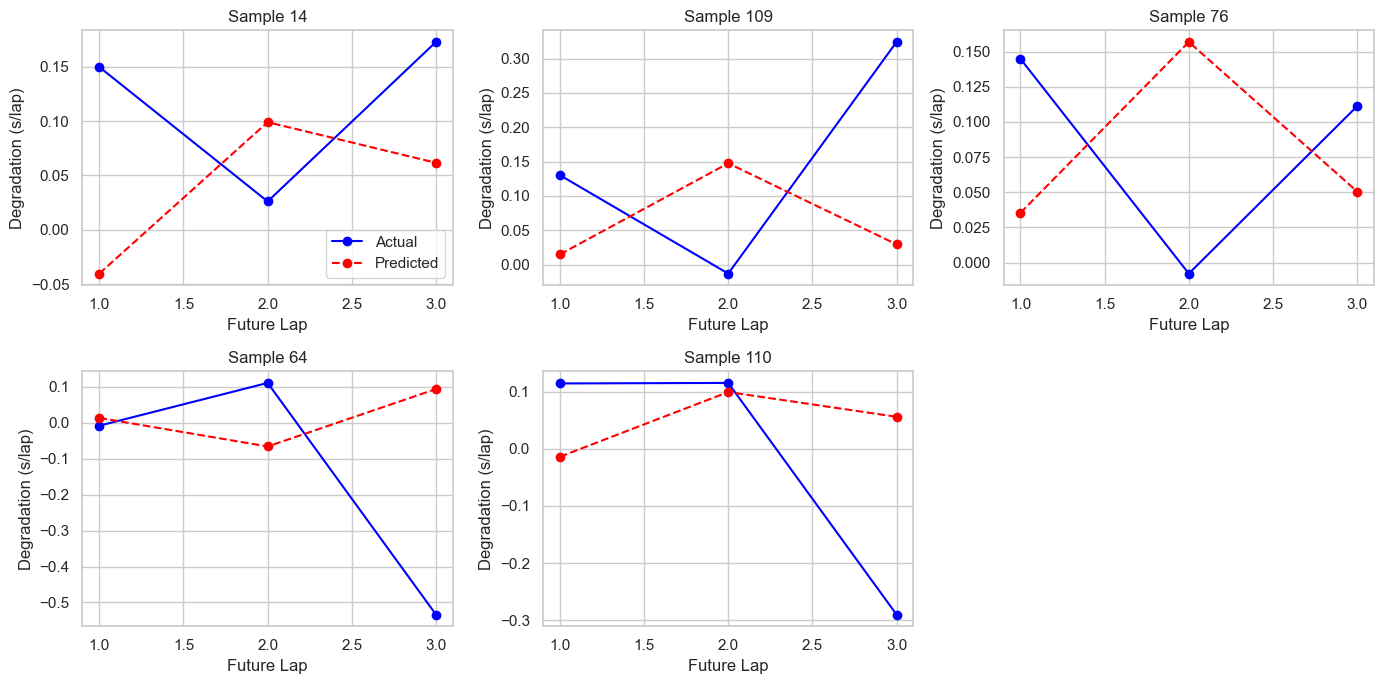

In [66]:
plt.figure(figsize=(14, 7))

# Select some samples for visualizing
sample_indices = np.random.choice(len(predictions), size=5, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+1)
    
    horizon = range(1, 4)  # 3 future laps
    
    plt.plot(horizon, actuals[idx], 'o-', label='Actual', color='blue')
    plt.plot(horizon, predictions[idx], 'o--', label='Predicted', color='red')
    
    plt.title(f'Sample {idx}')
    plt.xlabel('Future Lap')
    plt.ylabel('Degradation (s/lap)')
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.savefig('../../outputs/week5/predictions_vs_actual.png')
plt.show()

---

### 22.3 Performance Comparison by Compound


Performance by Compound:
Compound        MSE          RMSE         MAE         
-------------------------------------------------------
MEDIUM          0.180598     0.424969     0.284657    
HARD            0.068611     0.261937     0.173940    
SOFT            0.229746     0.479319     0.279915    
GLOBAL MODEL    0.126593     0.355799     0.232302    


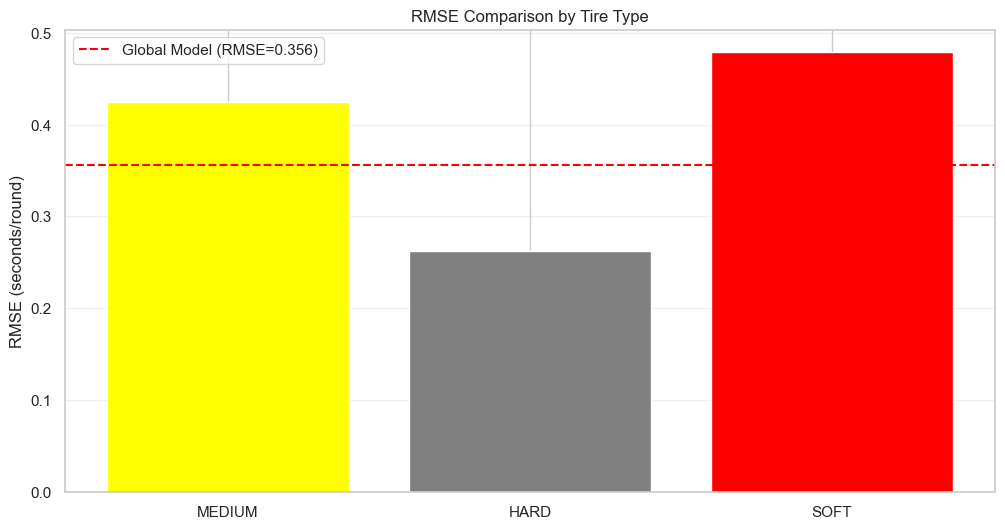

In [67]:
# Display table header for metrics per compound
print("\nPerformance by Compound:")
# Format the header with columns for Compound, MSE, RMSE, and MAE
print("{:<15} {:<12} {:<12} {:<12}".format("Compound", "MSE", "RMSE", "MAE"))
print("-" * 55)  # Print a separator line

# Create a dictionary for the global metrics from previously computed values
global_metrics = {"mse": mse, "rmse": rmse, "mae": mae}

# Loop through each compound and its corresponding performance metrics
for compound, metrics in compound_performance.items():
    # Retrieve the compound name from the dictionary, or default to "Compound <id>"
    compound_name = compound_names.get(compound, f"Compound {compound}")
    
    # Print the metrics for the current compound, formatted with 6 decimal places
    print("{:<15} {:<12.6f} {:<12.6f} {:<12.6f}".format(
        compound_name, 
        metrics['mse'], 
        metrics['rmse'], 
        metrics['mae']
    ))

# Add the global model metrics for comparison, using the same formatting
print("{:<15} {:<12.6f} {:<12.6f} {:<12.6f}".format(
    "GLOBAL MODEL", 
    global_metrics['mse'], 
    global_metrics['rmse'], 
    global_metrics['mae']
))

# Create a bar chart to visually compare the RMSE of each compound model against the global model

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Extract the compound identifiers from the performance dictionary keys
compounds = list(compound_performance.keys())
# Create a list of RMSE values for each compound from the performance metrics
rmse_values = [metrics['rmse'] for metrics in compound_performance.values()]
# Create a list of compound labels using the compound_names dictionary, defaulting if not found
compound_labels = [compound_names.get(c, f"Compound {c}") for c in compounds]

# Define colors for each compound using a dictionary, defaulting to 'gray' if the compound is not specified
colors = [compound_colors.get(c, 'gray') for c in compounds]

# Plot a bar chart where each bar corresponds to the RMSE value of a compound model
plt.bar(compound_labels, rmse_values, color=colors)

# Draw a horizontal dashed red line representing the global model's RMSE for easy comparison
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Global Model (RMSE={rmse:.3f})')

# Label the y-axis with a description and the measurement units (seconds/round)
plt.ylabel('RMSE (seconds/round)')
# Set the title of the chart to describe the comparison being made
plt.title('RMSE Comparison by Tire Type')
# Add a legend to differentiate between the global model and compound-specific models
plt.legend()
# Enable grid lines for the y-axis to improve readability
plt.grid(axis='y', alpha=0.3)

# Save the figure to the specified output path
plt.savefig('../../outputs/week5/compound_specialized_performance.png')
# Display the plot
plt.show()


---

### 22.4 Visualizations of Predictions vs Actual Values by Compound


Visualizing predictions for MEDIUM...


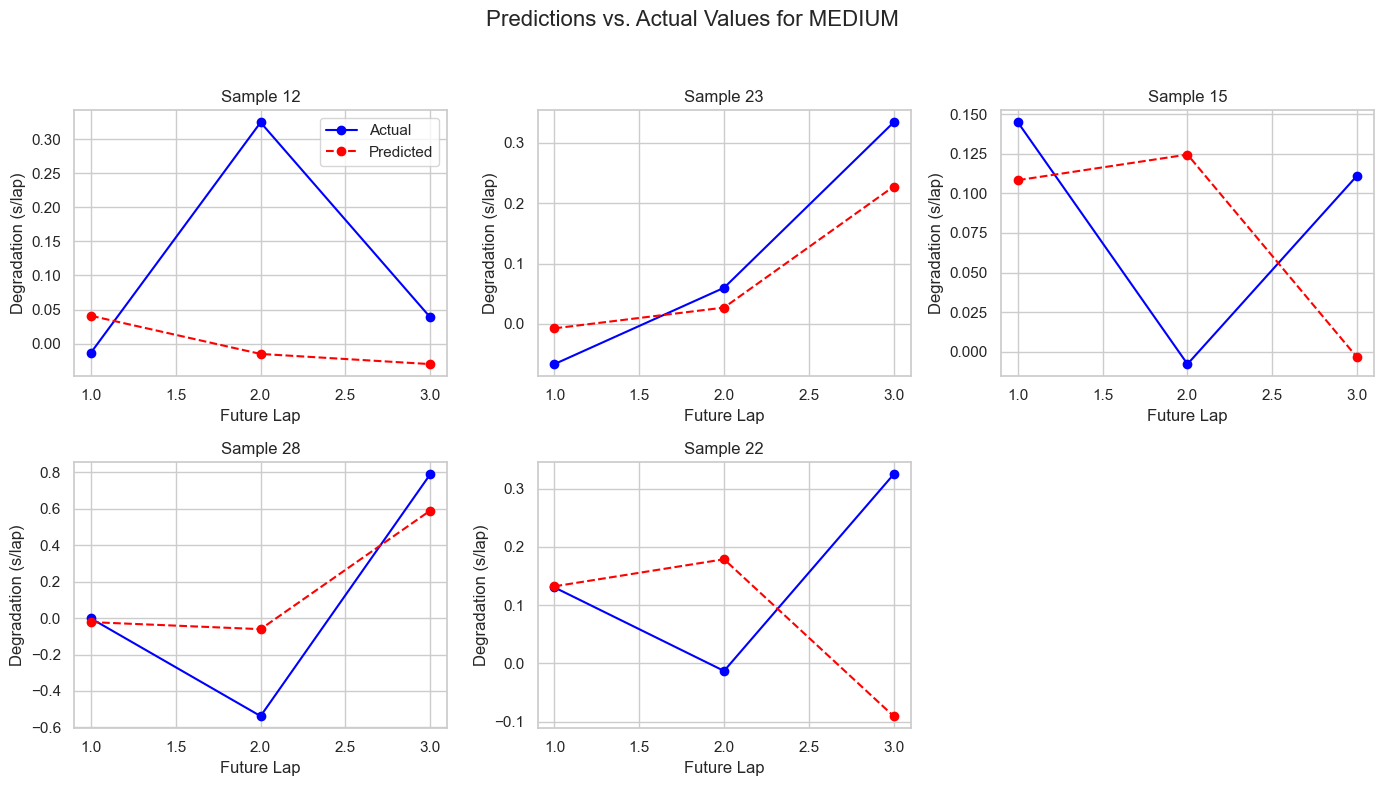


Visualizing predictions for HARD...


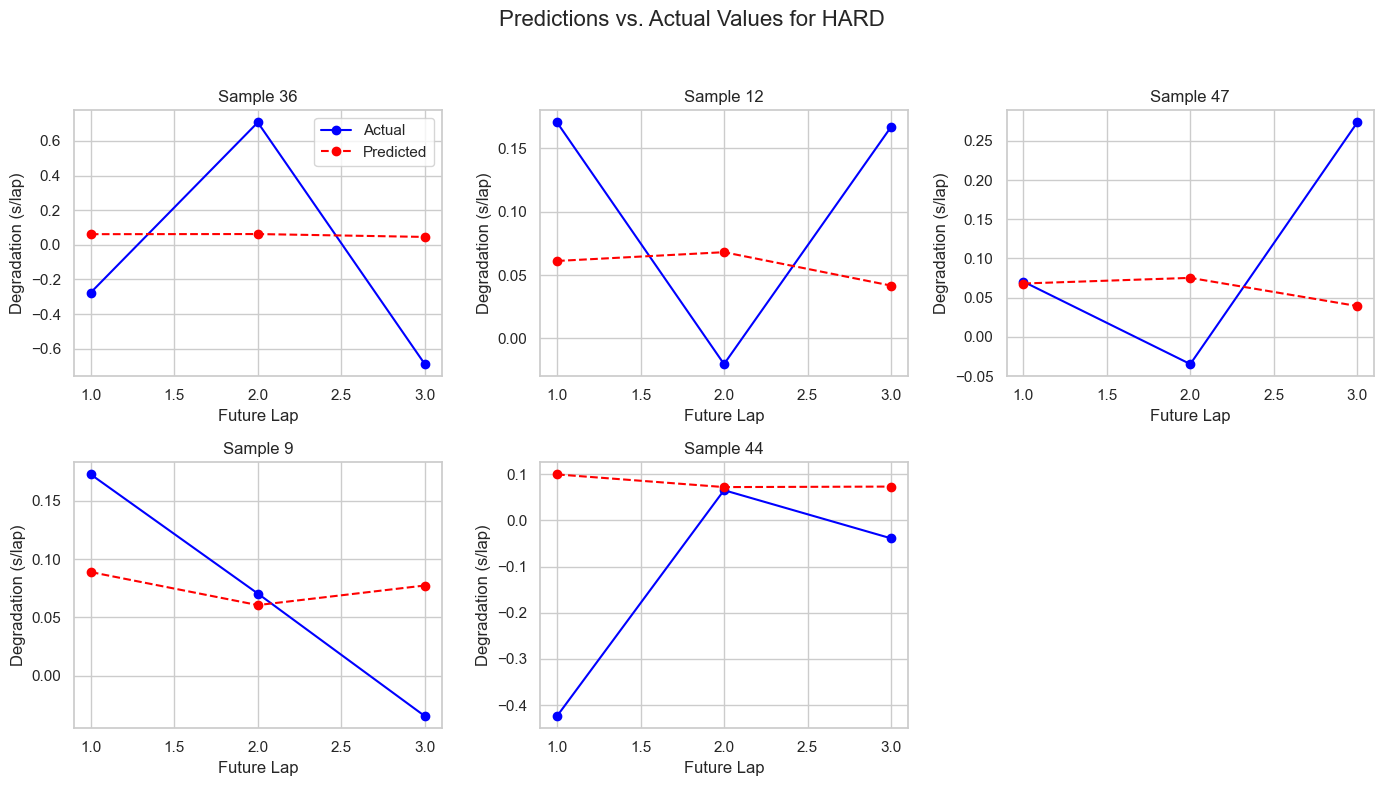


Visualizing predictions for SOFT...


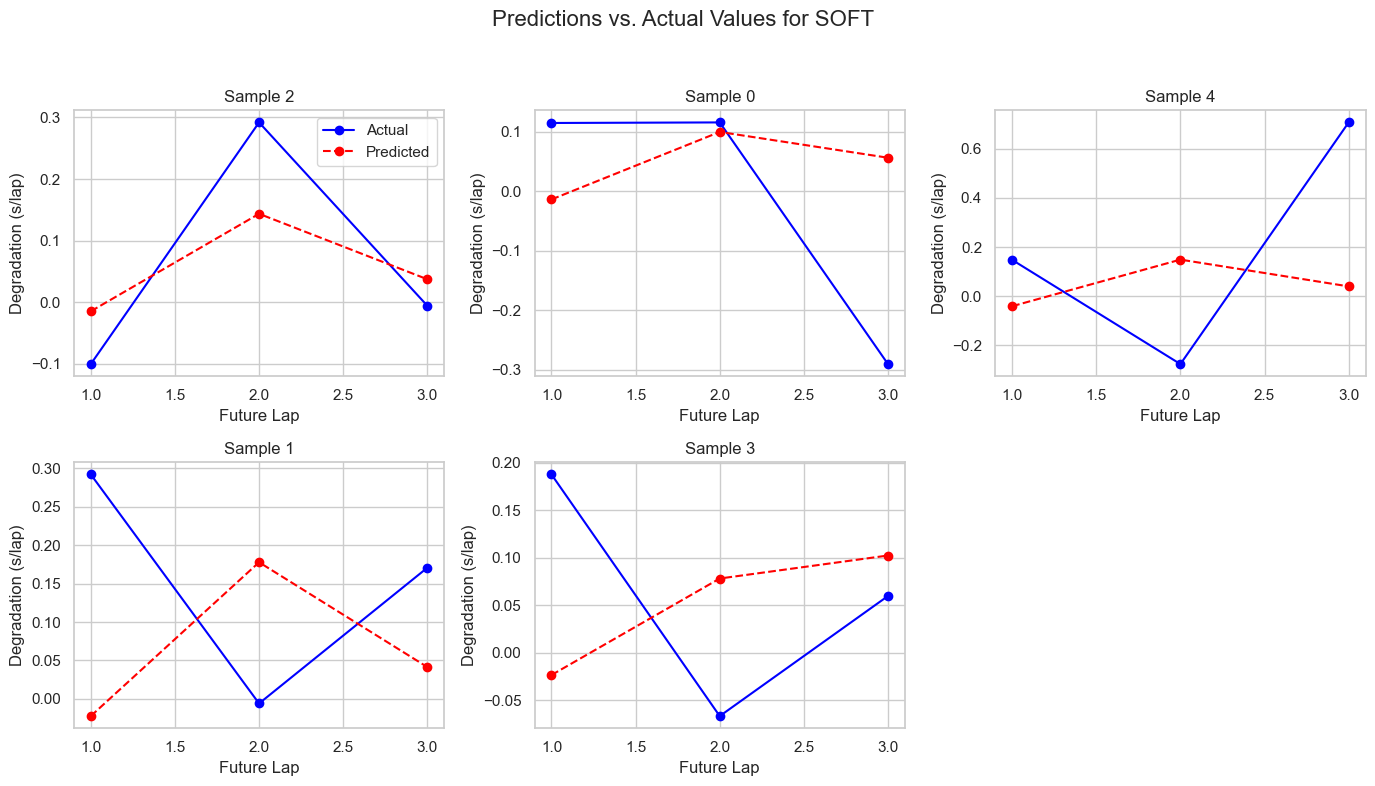

In [68]:
def visualize_compound_predictions(compound_id, compound_model, X_test, y_test, device):
    """
    Visualizes predictions versus actual values for a specific compound.
    """
    # Filter test data indices corresponding to this compound.
    compound_test_indices = []
    for i, sequence in enumerate(sequences):
        # Check if the current sequence belongs to the given compound using the 'CompoundID'
        if sequence['CompoundID'].iloc[0] == compound_id:
            compound_test_indices.append(i)
    
    # Convert the test data to a PyTorch tensor and send it to the specified device (CPU or GPU).
    X_compound = torch.FloatTensor(X_test).to(device)
    
    # Set the model to evaluation mode and compute predictions without tracking gradients.
    compound_model.eval()
    with torch.no_grad():
        y_pred = compound_model(X_compound).cpu().numpy()
    
    # y_actual remains the provided ground truth values for comparison.
    y_actual = y_test
    
    # Determine the number of samples to visualize (up to 5 samples, or less if fewer predictions exist)
    n_samples = min(5, len(y_pred))
    if n_samples > 0:
        # Randomly select sample indices without replacement.
        sample_indices = np.random.choice(len(y_pred), size=n_samples, replace=False)
        
        # Create a figure with a grid of subplots (2 rows and 3 columns) to display each sample.
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
        axes = axes.flatten()  # Flatten the 2D array of axes to a 1D list for easier indexing.
        
        # Retrieve the compound name from the dictionary, or default to "Compound <compound_id>".
        compound_name = compound_names.get(compound_id, f"Compound {compound_id}")
        fig.suptitle(f'Predictions vs. Actual Values for {compound_name}', fontsize=16)
        
        # Plot each selected sample in a separate subplot.
        for i, idx in enumerate(sample_indices):
            if i < len(axes):
                ax = axes[i]
                
                # Define the forecast horizon; here, we assume predictions for 3 future laps.
                horizon = range(1, 4)  # Future laps: 1, 2, 3
                
                # Plot the actual values as a blue solid line with markers.
                ax.plot(horizon, y_actual[idx], 'o-', label='Actual', color='blue')
                # Plot the predicted values as a red dashed line with markers.
                ax.plot(horizon, y_pred[idx], 'o--', label='Predicted', color='red')
                
                # Set subplot title, labels, and enable grid lines.
                ax.set_title(f'Sample {idx}')
                ax.set_xlabel('Future Lap')
                ax.set_ylabel('Degradation (s/lap)')
                ax.grid(True)
                
                # Only add a legend to the first subplot.
                if i == 0:
                    ax.legend()
        
        # Turn off any unused subplots if less than the available axes.
        for i in range(n_samples, len(axes)):
            axes[i].axis('off')
        
        # Adjust the layout to accommodate the figure title and subplots.
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # Save the figure to the specified output path, including the compound name in the filename.
        plt.savefig(f'../../outputs/week5/predictions_{compound_name}.png')
        plt.show()
    else:
        print(f"There are not enough samples to visualize for compound {compound_name}")

# Visualize predictions for each compound in the specialized models.
for compound in specialized_models:
    # Retrieve the compound name using the compound_names dictionary.
    compound_name = compound_names.get(compound, f"Compound {compound}")
    print(f"\nVisualizing predictions for {compound_name}...")
    
    # Filter the test data indices for this compound.
    compound_indices_test = []
    for i, seq in enumerate(sequences):
        # Ensure that the index is within the bounds of the test data and matches the compound.
        if i < len(X_test) and seq['CompoundID'].iloc[0] == compound:
            compound_indices_test.append(i)
    
    # If there are test samples for this compound, proceed with visualization.
    if len(compound_indices_test) > 0:
        # Filter the test data (both features and labels) using the collected indices.
        X_compound_test = X_test[compound_indices_test]
        y_compound_test = y_test[compound_indices_test]
        
        # Call the visualization function with the filtered data.
        visualize_compound_predictions(compound, specialized_models[compound], 
                                      X_compound_test, y_compound_test, device)
    else:
        print(f"There is no test data for compound {compound_name}")


---

### 22.5 Compare Learning Curves by Compound

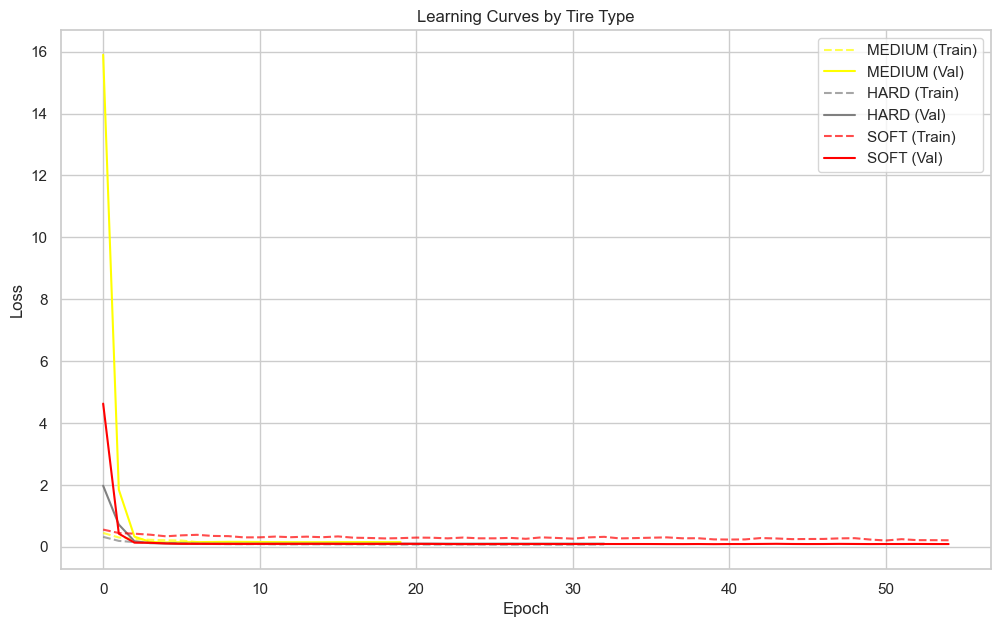

In [69]:
plt.figure(figsize=(12, 7))  # Set the size of the figure

# Loop through each compound's loss curves data
for compound in compound_loss_curves:
    # Retrieve the compound name from the dictionary, defaulting to "Compound <id>" if not found
    compound_name = compound_names.get(compound, f"Compound {compound}")
    # Get the color for the compound; default to black if not specified
    color = compound_colors.get(compound, 'black')
    
    # Each entry in compound_loss_curves is a tuple: (training loss curve, validation loss curve)
    train_curve, val_curve = compound_loss_curves[compound]
    
    # Plot the training loss curve using a dashed line with some transparency
    plt.plot(train_curve, '--', color=color, alpha=0.7, 
             label=f'{compound_name} (Train)')
    # Plot the validation loss curve using a solid line
    plt.plot(val_curve, '-', color=color, 
             label=f'{compound_name} (Val)')

# Set the x-axis label to "Epoch"
plt.xlabel('Epoch')
# Set the y-axis label to "Loss"
plt.ylabel('Loss')
# Set the title for the plot
plt.title('Learning Curves by Tire Type')
# Display a legend to differentiate between compounds and data types (training vs validation)
plt.legend()
# Enable grid lines for better readability
plt.grid(True)
# Save the figure to the specified output path
plt.savefig('../../outputs/week5/learning_curves_by_compound.png')
# Display the plot
plt.show()


---

## 23. Ensemble System for Combined Predictions

In [70]:
def ensemble_predict(X, compound_id, global_model, specialized_models, device, 
                     weights=None):
    """
    Makes predictions using an ensemble of the global model and the specialized model.
    
    Args:
        X: Input data (tensor)
        compound_id: ID of the compound for which the prediction is made
        global_model: Global model trained on all data
        specialized_models: Dictionary containing specialized models for each compound
        device: Device for computation (CPU/GPU)
        weights: Weights to combine predictions [global_weight, specialized_weight]
                 If None, weights are calculated based on the inverse RMSE.
    
    Returns:
        Ensemble predictions and the weights used for combining
    """
    # Convert X to a tensor if it is not already one.
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    
    # Move the input tensor to the specified device (CPU/GPU)
    X = X.to(device)
    
    # Get predictions from the global model.
    # Set the model to evaluation mode and disable gradient computation.
    global_model.eval()
    with torch.no_grad():
        global_pred = global_model(X).cpu().numpy()
    
    # Check if there is a specialized model for the given compound.
    if compound_id in specialized_models:
        specialized_model = specialized_models[compound_id]
        specialized_model.eval()
        with torch.no_grad():
            specialized_pred = specialized_model(X).cpu().numpy()
            
        # If weights are not provided, calculate them based on the inverse of the RMSE.
        if weights is None:
            global_rmse = 0.355017  # RMSE of the global model
            specialized_rmse = compound_performance[compound_id]['rmse']
            
            # Use the inverse of the RMSE as the weighting factor (better performance = higher weight)
            global_weight = 1 / global_rmse
            specialized_weight = 1 / specialized_rmse
            
            # Normalize the weights so that their sum is equal to 1.
            total = global_weight + specialized_weight
            global_weight /= total
            specialized_weight /= total
            
            weights = [global_weight, specialized_weight]
        
        # Combine the predictions from the global and specialized models using the calculated weights.
        ensemble_pred = weights[0] * global_pred + weights[1] * specialized_pred
        
        return ensemble_pred, weights
    else:
        # If no specialized model exists, return only the global prediction.
        return global_pred, [1.0, 0.0]

# Evaluate the performance of the ensemble system.
ensemble_predictions = []      # List to store ensemble predictions for each compound.
ensemble_weights_used = {}     # Dictionary to store average weights used for each compound.

print("\nEvaluating Ensemble System:")
test_indices_by_compound = {}  # Dictionary to group test indices by compound.

# Group test indices by compound.
for i in range(len(X_test)):
    # Get the compound associated with the i-th test example.
    # We need to link it with the original sequence.
    test_sequence_idx = i % len(sequences)  # Approximation; adjust if necessary.
    if test_sequence_idx < len(sequences):
        compound_id = sequences[test_sequence_idx]['CompoundID'].iloc[0]
        
        if compound_id not in test_indices_by_compound:
            test_indices_by_compound[compound_id] = []
        
        test_indices_by_compound[compound_id].append(i)

# Evaluate the ensemble for each compound.
for compound_id, indices in test_indices_by_compound.items():
    # Retrieve compound name from dictionary; default if not found.
    compound_name = compound_names.get(compound_id, f"Compound {compound_id}")
    # Filter the test data (features and labels) for the current compound.
    X_compound = X_test[indices]
    y_compound = y_test[indices]
    
    compound_predictions = []  # List to store predictions for this compound.
    weights_sum = [0, 0]       # To accumulate the weights used over all samples.
    
    # Iterate through each test sample for the current compound.
    for i, x in enumerate(X_compound):
        # Reshape the sample to have a batch dimension of 1.
        x_tensor = torch.FloatTensor(x.reshape(1, x.shape[0], x.shape[1]))
        # Get the ensemble prediction and the weights used for this sample.
        pred, weights = ensemble_predict(x_tensor, compound_id, model, 
                                         specialized_models, device)
        compound_predictions.append(pred[0])
        # Sum the weights for averaging later.
        weights_sum[0] += weights[0]
        weights_sum[1] += weights[1]
    
    # Calculate average weights used across all samples for the compound.
    if len(X_compound) > 0:
        avg_weights = [w / len(X_compound) for w in weights_sum]
        ensemble_weights_used[compound_id] = avg_weights
    
    # Convert the predictions list to a NumPy array.
    compound_predictions = np.array(compound_predictions)
    
    # Calculate evaluation metrics: Mean Squared Error, RMSE, and Mean Absolute Error.
    mse = mean_squared_error(y_compound, compound_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_compound, compound_predictions)
    
    # Retrieve the RMSE of the global and specialized models.
    global_rmse = 0.355017
    specialized_rmse = compound_performance.get(compound_id, {'rmse': float('inf')})['rmse']
    
    # Calculate the percentage improvement of the ensemble over the global and specialized models.
    improvement_over_global = (global_rmse - rmse) / global_rmse * 100
    improvement_over_specialized = (specialized_rmse - rmse) / specialized_rmse * 100
    
    # Print performance metrics for the current compound.
    print(f"\n{compound_name}:")
    print(f"  Ensemble RMSE: {rmse:.6f}")
    print(f"  Global RMSE: {global_rmse:.6f} ({improvement_over_global:.2f}% improvement)")
    print(f"  Specialized RMSE: {specialized_rmse:.6f} ({improvement_over_specialized:.2f}% improvement)")
    print(f"  Weights used: Global={avg_weights[0]:.2f}, Specialized={avg_weights[1]:.2f}")
    
    # Save predictions for visualization.
    ensemble_predictions.append((compound_id, compound_predictions, y_compound))



Evaluating Ensemble System:

MEDIUM:
  Ensemble RMSE: 0.319316
  Global RMSE: 0.355017 (10.06% improvement)
  Specialized RMSE: 0.424969 (24.86% improvement)
  Weights used: Global=0.54, Specialized=0.46

HARD:
  Ensemble RMSE: 0.382421
  Global RMSE: 0.355017 (-7.72% improvement)
  Specialized RMSE: 0.261937 (-46.00% improvement)
  Weights used: Global=0.42, Specialized=0.58

SOFT:
  Ensemble RMSE: 0.264008
  Global RMSE: 0.355017 (25.63% improvement)
  Specialized RMSE: 0.479319 (44.92% improvement)
  Weights used: Global=0.57, Specialized=0.43


---

## Visualization of Ensemble Predictions

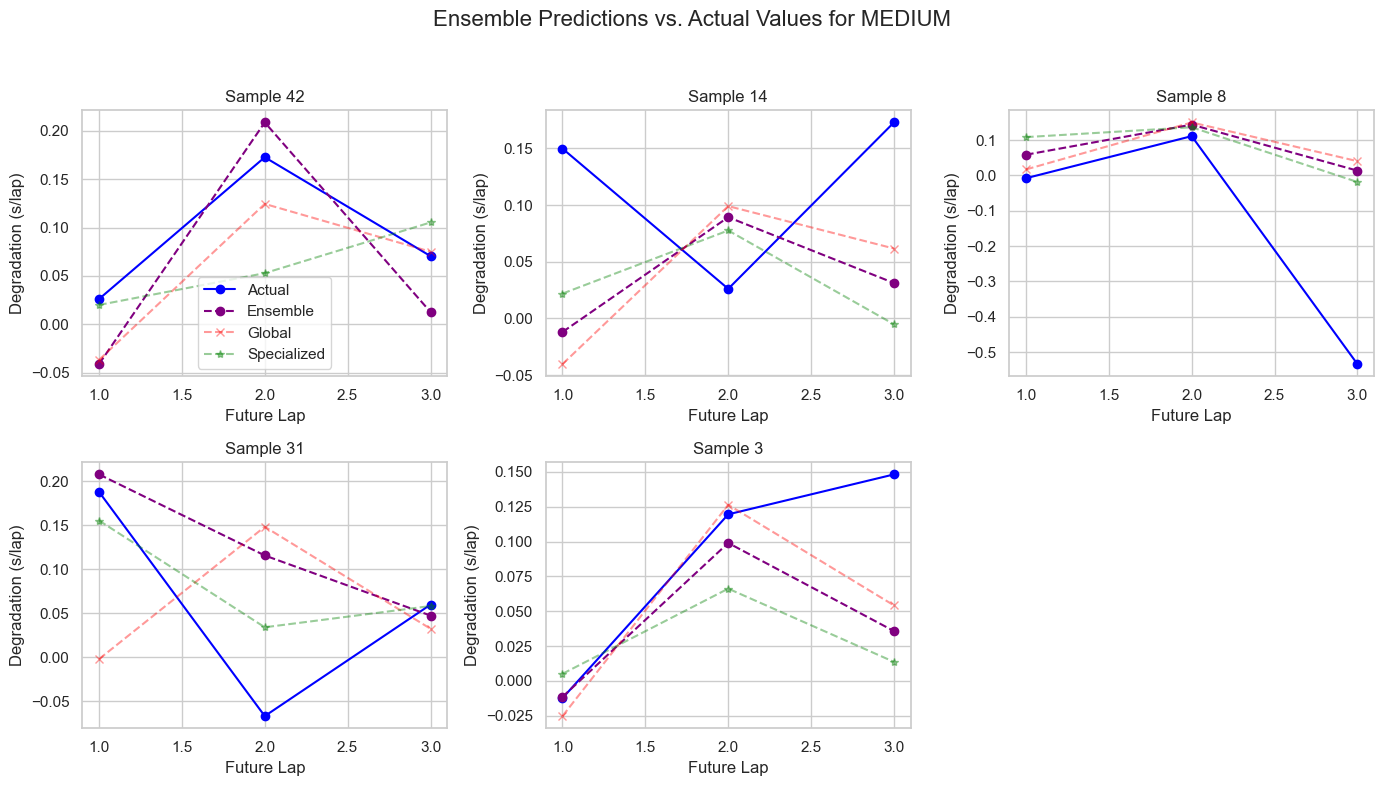

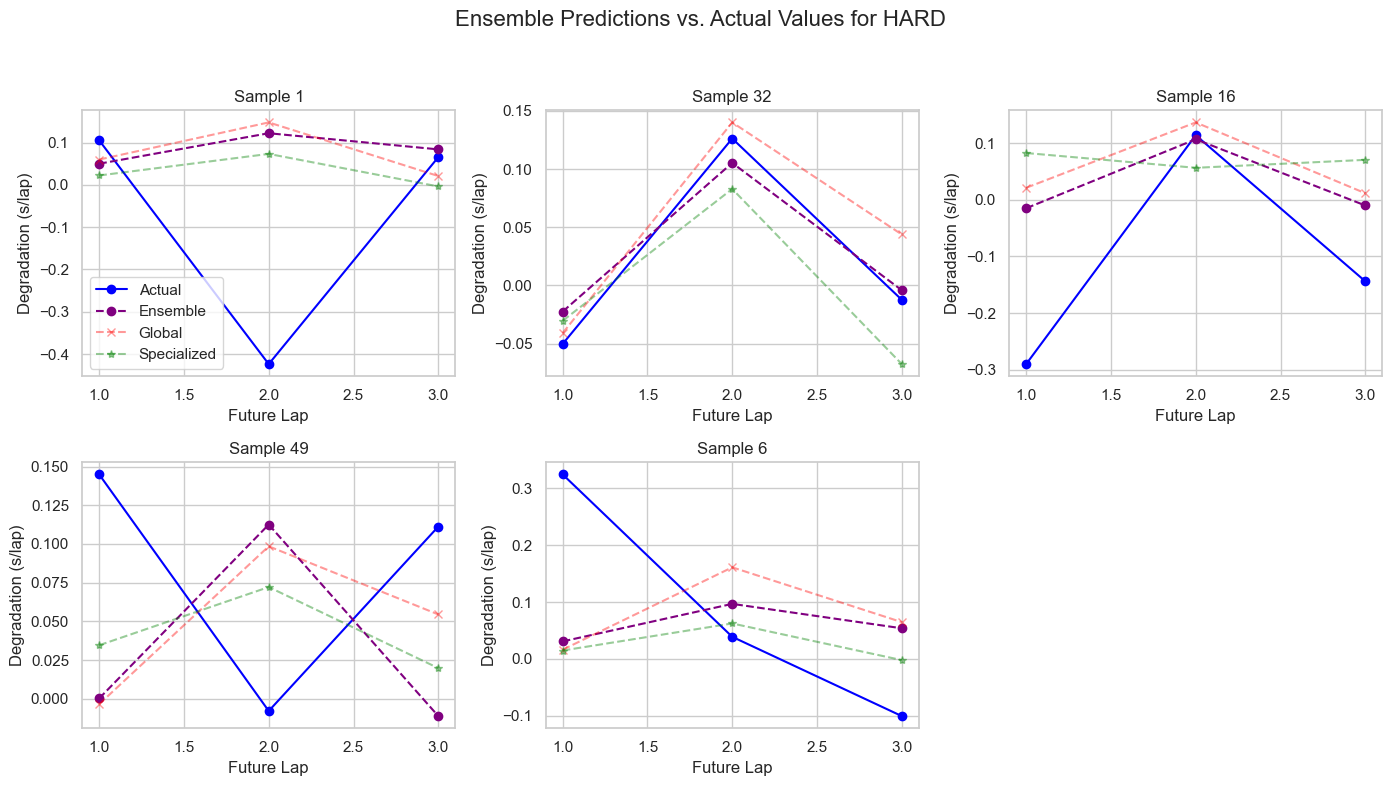

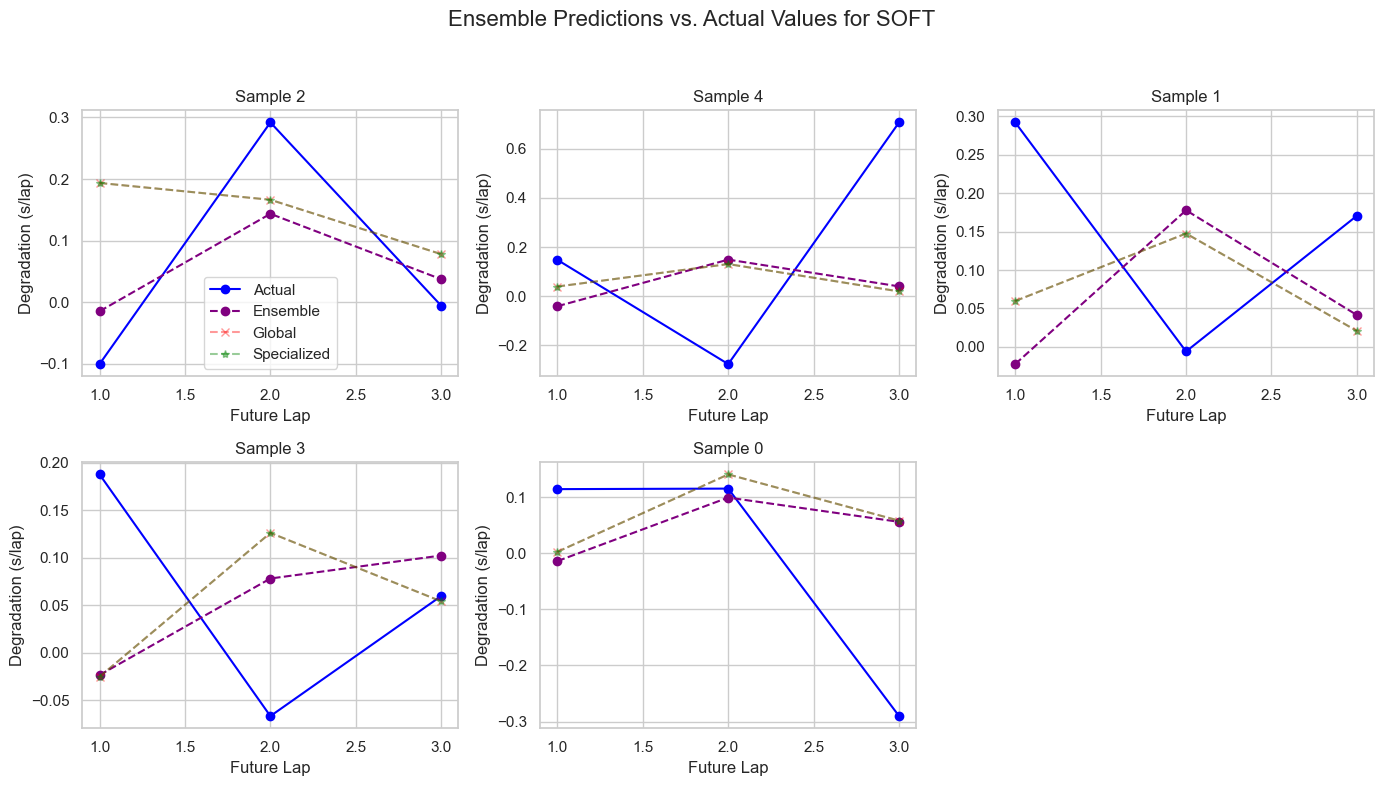

In [71]:
def visualize_ensemble_predictions(ensemble_results):
    """
    Visualizes the ensemble model's predictions against the actual values.
    
    Args:
        ensemble_results: List of tuples (compound_id, predictions, actuals)
    """
    # Iterate over each compound's ensemble results
    for compound_id, predictions, actuals in ensemble_results:
        # Retrieve the compound name from the dictionary, or default if not found
        compound_name = compound_names.get(compound_id, f"Compound {compound_id}")
        
        # Select up to 5 samples to visualize
        n_samples = min(5, len(predictions))
        if n_samples == 0:
            continue  # Skip if there are no samples
        
        # Randomly choose sample indices without replacement
        sample_indices = np.random.choice(len(predictions), size=n_samples, replace=False)
        
        # Create a figure with a grid of subplots (2 rows x 3 columns)
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
        axes = axes.flatten()  # Flatten to simplify indexing
        
        # Set the overall title for the figure
        fig.suptitle(f'Ensemble Predictions vs. Actual Values for {compound_name}', fontsize=16)
        
        # Loop over each selected sample index to plot
        for i, idx in enumerate(sample_indices):
            if i < len(axes):
                ax = axes[i]
                
                # Define the forecast horizon (here, 3 future laps)
                horizon = range(1, 4)
                
                # Prepare the input sample for prediction by reshaping and sending to device
                # Assuming each sample has a shape that should be reshaped to (1, 5, 16)
                x_tensor = torch.FloatTensor(X_test[idx].reshape(1, 5, 16)).to(device)
                
                # Obtain the global model prediction for the sample
                with torch.no_grad():
                    global_pred = model(x_tensor).cpu().numpy()[0]
                
                # Check if there is a specialized model for this compound; if so, use it
                if compound_id in specialized_models:
                    specialized_model = specialized_models[compound_id]
                    with torch.no_grad():
                        specialized_pred = specialized_model(x_tensor).cpu().numpy()[0]
                else:
                    specialized_pred = global_pred  # Fallback to global prediction
                
                # Plot the actual values as a blue line with markers
                ax.plot(horizon, actuals[idx], 'o-', label='Actual', color='blue')
                # Plot the ensemble prediction as a purple dashed line with markers
                ax.plot(horizon, predictions[idx], 'o--', label='Ensemble', color='purple')
                # Plot the global model prediction as a red dashed line with a different marker, semi-transparent
                ax.plot(horizon, global_pred, 'x--', label='Global', color='red', alpha=0.4)
                # Plot the specialized model prediction as a green dashed line with a different marker, semi-transparent
                ax.plot(horizon, specialized_pred, '*--', label='Specialized', color='green', alpha=0.4)
                
                # Set subplot title and axis labels
                ax.set_title(f'Sample {idx}')
                ax.set_xlabel('Future Lap')
                ax.set_ylabel('Degradation (s/lap)')
                ax.grid(True)
                
                # Only add a legend in the first subplot for clarity
                if i == 0:
                    ax.legend()
        
        # Hide any unused subplots in the grid
        for i in range(n_samples, len(axes)):
            axes[i].axis('off')
        
        # Adjust layout to ensure the overall title does not overlap with subplots
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # Save the figure to the specified file path
        plt.savefig(f'../../outputs/week5/ensemble_predictions_{compound_name}.png')
        # Display the plot
        plt.show()

# Visualize ensemble predictions using the results from the ensemble evaluation
visualize_ensemble_predictions(ensemble_predictions)


---

## 25. Functions for making further Predictions

### 25.1 Making Predictions with the ensemble Model

### 25.2 Process raw lap data for the models

---

## 26. Simple Simulation for Example usage

---